In [ ]:
import zipfile
from pathlib import Path

import cdsapi
from huggingface_hub import hf_hub_download

# Data will be downloaded here.
download_path = Path("~/downloads/cams")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables from HuggingFace.
static_path = hf_hub_download(
    repo_id="microsoft/aurora",
    filename="aurora-0.4-air-pollution-static.pickle",
    local_dir="~/downloads/cams"
)
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2022-06-11-cams.nc.zip").exists():
    c = cdsapi.Client()
    c.retrieve(
        "cams-global-atmospheric-composition-forecasts",
        {
            "type": "forecast",
            "leadtime_hour": "0",
            "variable": [
                # Meteorological surface-level variables:
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "2m_temperature",
                "mean_sea_level_pressure",
                # Pollution surface-level variables:
                "particulate_matter_1um",
                "particulate_matter_2.5um",
                "particulate_matter_10um",
                "total_column_carbon_monoxide",
                "total_column_nitrogen_monoxide",
                "total_column_nitrogen_dioxide",
                "total_column_ozone",
                "total_column_sulphur_dioxide",
                # Meteorological atmospheric variables:
                "u_component_of_wind",
                "v_component_of_wind",
                "temperature",
                "geopotential",
                "specific_humidity",
                # Pollution atmospheric variables:
                "carbon_monoxide",
                "nitrogen_dioxide",
                "nitrogen_monoxide",
                "ozone",
                "sulphur_dioxide",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "date": "2022-06-11",
            "time": ["00:00", "12:00"],
            "format": "netcdf_zip",
        },
        str(download_path / "2022-06-11-cams.nc.zip"),
    )
# Unpack the ZIP. It should contain the surface-level and atmospheric data in separate
# files.
if not (download_path / "2022-06-11-cams-surface-level.nc").exists():
    with zipfile.ZipFile(download_path / "2022-06-11-cams.nc.zip", "r") as zf, open(
        download_path / "2022-06-11-cams-surface-level.nc", "wb"
    ) as f:
        f.write(zf.read("data_sfc.nc"))
if not (download_path / "2022-06-11-cams-atmospheric.nc").exists():
    with zipfile.ZipFile(download_path / "2022-06-11-cams.nc.zip", "r") as zf, open(
        download_path / "2022-06-11-cams-atmospheric.nc", "wb"
    ) as f:
        f.write(zf.read("data_plev.nc"))
print("Surface-level and atmospheric variables downloaded!")

In [ ]:
#### ##############################################################
# AuroraAirPollution model with the downloaded data #
#### ##############################################################

import pickle, torch, xarray as xr, numpy as np, gc
from aurora import Batch, Metadata, AuroraAirPollution, rollout
from huggingface_hub import hf_hub_download
from pathlib import Path

# --- load statics ---
download_path = Path("~/downloads/cams").expanduser()
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")
with open(static_path, "rb") as f:
    static_vars = pickle.load(f)

# --- open datasets (must contain 2 time steps for history) ---
surf_var_ds = xr.open_dataset(download_path / "2022-06-11-cams-surface-level.nc", engine="netcdf4", decode_timedelta=True)
atmos_vars_ds = xr.open_dataset(download_path / "2022-06-11-cams-atmospheric.nc",   engine="netcdf4", decode_timedelta=True)


surf_var_ds = surf_var_ds.isel(forecast_period=0)
atmos_vars_ds = atmos_vars_ds.isel(forecast_period=0)

# --- build model & get patch size AFTER loading checkpoint ---
model = AuroraAirPollution()
model.load_checkpoint("microsoft/aurora", "aurora-0.4-air-pollution.ckpt")
model.eval()
ps = int(model.patch_size)
print("model.patch_size =", ps)

# --- choose a safe spatial window (H,W are multiples of ps and >= 2*ps; 4*ps is safer) ---
H = W = 4 * ps
lat_len, lon_len = surf_var_ds.sizes["latitude"], surf_var_ds.sizes["longitude"]
H = min((lat_len // ps) * ps, H)
W = min((lon_len // ps) * ps, W)
if H < 2*ps or W < 2*ps:
    raise ValueError(f"Dataset too small for patch_size={ps}: choose smaller ps or use a different file.")

def center_start(total, window): return max(0, (total - window) // 2)
i0 = center_start(lat_len, H)
j0 = center_start(lon_len, W)

surf = surf_var_ds.isel(latitude=slice(i0, i0+H), longitude=slice(j0, j0+W))
atmo = atmos_vars_ds.isel(latitude=slice(i0, i0+H), longitude=slice(j0, j0+W))

# --- quick shape checks: we want time/history dimension = 2, spatial = HxW ---
print("surf t2m shape:", surf["t2m"].shape)     # (time=2, H, W) or (something,2,H,W) depending on file
print("atmo t shape:",  atmo["t"].shape)        # (time=2, level, H, W)

# --- subset static vars to same HxW ---
def subset_static(a):
    # static arrays are typically (H,W) or (C,H,W) or (C,lat,lon)
    if a.ndim == 3: return a[:, i0:i0+H, j0:j0+W]
    if a.ndim == 2: return a[i0:i0+H, j0:j0+W]
    return a
static_vars = {k: subset_static(v) for k, v in static_vars.items()}

# --- build Batch (each tensor: (B, T, H, W) or (B, T, L, H, W) for atmos) ---
# Add batch dim with [None]; time dimension must already be 2 in the data.
surf_vars = {
    "2t":   torch.from_numpy(surf["t2m"].values[None]),
    "10u":  torch.from_numpy(surf["u10"].values[None]),
    "10v":  torch.from_numpy(surf["v10"].values[None]),
    "msl":  torch.from_numpy(surf["msl"].values[None]),
    "pm1":  torch.from_numpy(surf["pm1"].values[None]),
    "pm2p5":torch.from_numpy(surf["pm2p5"].values[None]),
    "pm10": torch.from_numpy(surf["pm10"].values[None]),
    "tcco": torch.from_numpy(surf["tcco"].values[None]),
    "tc_no":torch.from_numpy(surf["tc_no"].values[None]),
    "tcno2":torch.from_numpy(surf["tcno2"].values[None]),
    "gtco3":torch.from_numpy(surf["gtco3"].values[None]),
    "tcso2":torch.from_numpy(surf["tcso2"].values[None]),
}
atmos_vars = {
    "t":   torch.from_numpy(atmo["t"].values[None]),   # (B, T, L, H, W)
    "u":   torch.from_numpy(atmo["u"].values[None]),
    "v":   torch.from_numpy(atmo["v"].values[None]),
    "q":   torch.from_numpy(atmo["q"].values[None]),
    "z":   torch.from_numpy(atmo["z"].values[None]),
    "co":  torch.from_numpy(atmo["co"].values[None]),
    "no":  torch.from_numpy(atmo["no"].values[None]),
    "no2": torch.from_numpy(atmo["no2"].values[None]),
    "go3": torch.from_numpy(atmo["go3"].values[None]),
    "so2": torch.from_numpy(atmo["so2"].values[None]),
}

# metadata expects (H,), (W,), time tuple, and levels tuple
lat_vec = torch.from_numpy(atmo.latitude.values)   # shape (H,)
lon_vec = torch.from_numpy(atmo.longitude.values)  # shape (W,)
time_tuple = tuple(atmo.valid_time.values.astype("datetime64[s]").astype(object))
levels_tuple = tuple(int(x) for x in atmo.pressure_level.values)

batch = Batch(
    surf_vars=surf_vars,
    static_vars={k: torch.from_numpy(v) for k, v in static_vars.items()},
    atmos_vars=atmos_vars,
    metadata=Metadata(
        lat=lat_vec,
        lon=lon_vec,
        time=time_tuple,          # length should be 2 (prev, current)
        atmos_levels=levels_tuple
    ),
)

# --- run 1-step rollout on CPU ---
gc.collect(); torch.cuda.empty_cache()
# one-step prediction without the rollout concat logic
with torch.inference_mode():
    # predictions = [p.to("cpu") for p in rollout(model, batch, steps=4)]
    predictions = model(batch)          # or: pred = model.forward(batch)



In [ ]:
##############################################
# Aurora AirPollution tiled global PM10 with hand blending #
##############################################

# --- Aurora tiled global PM10 with feathered blending (CPU) ----------------
import pickle, gc
from pathlib import Path

import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ config / paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2022-06-11-cams-surface-level.nc"
atmo_path = download_path / "2022-06-11-cams-atmospheric.nc"
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ open datasets ------------------
surf_ds = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_ds = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)
print("Surface dataset variables:", list(surf_ds.data_vars))
print("Atmospheric dataset variables:", list(atmo_ds.data_vars))


print("before forecast period selection:")
print("Surface dataset dims:", surf_ds.dims)
print("Atmospheric dataset dims:", atmo_ds.dims)
print("Surface dataset sizes:", surf_ds.sizes)
print("Atmospheric dataset sizes:", atmo_ds.sizes)
print("Surface dataset coords:", list(surf_ds.coords))
print("Atmospheric dataset coords:", list(atmo_ds.coords))
print(f"surf_ds.longitude.shape: {surf_ds.longitude.shape}, surf_ds.latitude.shape: {surf_ds.latitude.shape}")
print(f"atmo_ds.longitude.shape: {atmo_ds.longitude.shape}, atmo_ds.latitude.shape: {atmo_ds.latitude.shape}")


# use analysis product; keep both time steps (00Z, 12Z)
print("after forecast period selection:")
if "forecast_period" in surf_ds.dims: surf_ds = surf_ds.isel(forecast_period=0)
if "forecast_period" in atmo_ds.dims: atmo_ds = atmo_ds.isel(forecast_period=0)
print("Surface dataset dims:", surf_ds.dims)
print("Atmospheric dataset dims:", atmo_ds.dims)
print("Surface dataset sizes:", surf_ds.sizes)
print("Atmospheric dataset sizes:", atmo_ds.sizes)
print("Surface dataset coords:", list(surf_ds.coords))
print("Atmospheric dataset coords:", list(atmo_ds.coords))
print(f"surf_ds.longitude.shape: {surf_ds.longitude.shape}, surf_ds.latitude.shape: {surf_ds.latitude.shape}")
print(f"atmo_ds.longitude.shape: {atmo_ds.longitude.shape}, atmo_ds.latitude.shape: {atmo_ds.latitude.shape}")



# ------------------ build model ------------------
model = AuroraAirPollution()
model.load_checkpoint("microsoft/aurora", "aurora-0.4-air-pollution.ckpt")
model.eval()
ps = int(model.patch_size)
print("patch_size:", ps)

# ------------------ sizes & crop to multiples of patch size ------------------
lat_len = surf_ds.sizes["latitude"]
lon_len = surf_ds.sizes["longitude"]
H = (lat_len // ps) * ps
W = (lon_len // ps) * ps
print(f"Original dataset size (HxW): {lat_len} x {lon_len}")
print(f"Global working size (HxW): {H} x {W}")

print(f"before cropping surf_ds.latitude.shape: {surf_ds.latitude.shape}, surf_ds.longitude.shape: {surf_ds.longitude.shape}")
surf_ds = surf_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
atmo_ds = atmo_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
print(f"after cropping surf_ds.latitude.shape: {surf_ds.latitude.shape}, surf_ds.longitude.shape: {surf_ds.longitude.shape}")

lat_vec_full = atmo_ds.latitude.values
lon_vec_full = atmo_ds.longitude.values
print("lat_vec_full.shape:", lat_vec_full.shape)
print("lon_vec_full.shape:", lon_vec_full.shape)

# ------------------ tiling parameters ------------------
tile   = 12 * ps         # tile height/width
overlap = 2 * ps         # a bit more overlap blends better than ps
step   = tile - overlap  # stride

# weighted accumulation buffers
accum = np.zeros((H, W), dtype=np.float32)
wsum  = np.zeros((H, W), dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

def hann_blend(h, w, edge):
    """2D separable raised-cosine feather that decays to 0 within 'edge' of borders."""
    edge = max(1, int(edge))
    def _ramp(n):
        r = np.ones(n, dtype=np.float32)
        # left
        wl = min(edge, n)
        if wl > 0:
            x = np.linspace(0, np.pi, wl, dtype=np.float32)
            r[:wl] = 0.5 - 0.5*np.cos(x)
        # right
        wr = min(edge, n)
        if wr > 0:
            x = np.linspace(np.pi, 0, wr, dtype=np.float32)
            r[-wr:] = 0.5 - 0.5*np.cos(x)
        return r
    ry = _ramp(h)
    rx = _ramp(w)
    return np.outer(ry, rx)

# ------------------ run tiled inference with blending ------------------
gc.collect(); torch.cuda.empty_cache()

for i in range(0, H, step):
    for j in range(0, W, step):
        hi = min(i + tile, H)
        wi = min(j + tile, W)
        # force each side to be a multiple of ps
        h = (hi - i) // ps * ps
        w = (wi - j) // ps * ps
        if h < ps or w < ps:
            continue
        ii = slice(i, i + h)
        jj = slice(j, j + w)

        # tile-specific blending mask (feather edge ~ half the overlap)
        weight = hann_blend(h, w, edge=overlap//2)

        # build tile datasets
        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)
        static_vars_tile = {k: subset_static_tile(v, ii, jj) for k, v in static_vars_full.items()}

        surf_vars = {
            "2t":    torch.from_numpy(surf_t["t2m" ].values[None]),
            "10u":   torch.from_numpy(surf_t["u10" ].values[None]),
            "10v":   torch.from_numpy(surf_t["v10" ].values[None]),
            "msl":   torch.from_numpy(surf_t["msl" ].values[None]),
            "pm1":   torch.from_numpy(surf_t["pm1" ].values[None]),
            "pm2p5": torch.from_numpy(surf_t["pm2p5"].values[None]),
            "pm10":  torch.from_numpy(surf_t["pm10"].values[None]),
            "tcco":  torch.from_numpy(surf_t["tcco"].values[None]),
            "tc_no": torch.from_numpy(surf_t["tc_no"].values[None]),
            "tcno2": torch.from_numpy(surf_t["tcno2"].values[None]),
            "gtco3": torch.from_numpy(surf_t["gtco3"].values[None]),
            "tcso2": torch.from_numpy(surf_t["tcso2"].values[None]),
        }
        atmos_vars = {
            "t":   torch.from_numpy(atmo_t["t" ].values[None]),
            "u":   torch.from_numpy(atmo_t["u" ].values[None]),
            "v":   torch.from_numpy(atmo_t["v" ].values[None]),
            "q":   torch.from_numpy(atmo_t["q" ].values[None]),
            "z":   torch.from_numpy(atmo_t["z" ].values[None]),
            "co":  torch.from_numpy(atmo_t["co"].values[None]),
            "no":  torch.from_numpy(atmo_t["no"].values[None]),
            "no2": torch.from_numpy(atmo_t["no2"].values[None]),
            "go3": torch.from_numpy(atmo_t["go3"].values[None]),
            "so2": torch.from_numpy(atmo_t["so2"].values[None]),
        }

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=torch.from_numpy(atmo_t.latitude.values),
                lon=torch.from_numpy(atmo_t.longitude.values),
                time=tuple(atmo_t.valid_time.values.astype("datetime64[s]").astype(object)),
                atmos_levels=tuple(int(x) for x in atmo_t.pressure_level.values),
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)

        # accumulate weighted
        accum[ii, jj] += tile_pm10 * weight
        wsum[ii, jj]  += weight

        # free
        del surf_t, atmo_t, static_vars_tile, batch_tile, pred_t, tile_pm10
        gc.collect()

# finalize stitched field
canvas = np.full((H, W), np.nan, dtype=np.float32)
mask = wsum > 0
canvas[mask] = accum[mask] / wsum[mask]

# ------------------ plotmap ------------------
pm10_disp = canvas / 1e-9  # µg m^-3 (×1e-9), for display

lat_plot = lat_vec_full.copy()
if lat_plot[0] > lat_plot[-1]:
    lat_plot = lat_plot[::-1]
    pm10_disp = pm10_disp[::-1, :]

extent = [lon_vec_full.min(), lon_vec_full.max(), lat_plot.min(), lat_plot.max()]

finite = np.isfinite(pm10_disp)
vmin, vmax = np.percentile(pm10_disp[finite], [5, 95])  # match your single-frame style

plt.figure(figsize=(12, 4.5))
# plt.imshow(pm10_disp, extent=extent, origin="lower",
#            cmap="Blues", interpolation="bilinear",
#            vmin=vmin, vmax=vmax, aspect="auto")
plt.imshow(pm10_disp, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("PM$_{10}$ global forecast")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$ (×1e-9)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3520631/140800860.py:25: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Surface dataset variables: ['u10', 'v10', 't2m', 'msl', 'tcco', 'tc_no', 'tcno2', 'gtco3', 'tcso2', 'pm1', 'pm2p5', 'pm10']
Atmospheric dataset variables: ['t', 'z', 'q', 'co', 'no2', 'no', 'go3', 'so2', 'u', 'v']
before forecast period selection:
Surface dataset dims: FrozenMappingWarningOnValuesAccess({'forecast_period': 1, 'forecast_reference_time': 2, 'latitude': 451, 'longitude': 900})
Atmospheric dataset dims: FrozenMappingWarningOnValuesAccess({'forecast_period': 1, 'forecast_reference_time': 2, 'pressure_level': 13, 'latitude': 451, 'longitude': 900})
Surface dataset sizes: Frozen({'forecast_period': 1, 'forecast_reference_time': 2, 'latitude': 451, 'longitude': 900})
Atmospheric dataset sizes: Frozen({'forecast_period': 1, 'forecast_reference_time': 2, 'pressure_level': 13, 'latitude': 451, 'longitude': 900})
Surface dataset coords: ['forecast_period', 'forecast_reference_time', 'latitude', 'longitude', 'valid_time']
Atmospheric dataset coords: ['forecast_period', 'forecast_re

/tmp/ipykernel_3157568/767423920.py:27: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


patch_size: 3
Original dataset size (HxW): 451 x 900
Global working size (HxW): 450 x 900


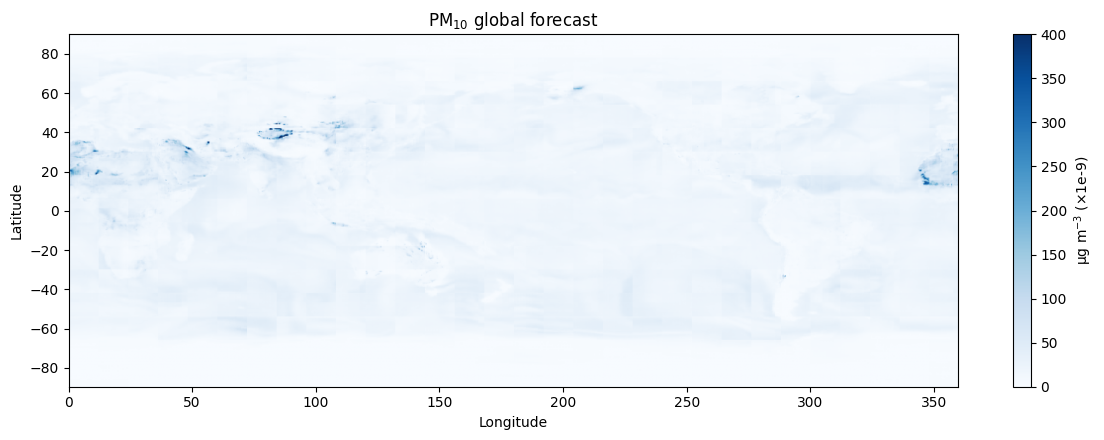


Predicted PM10 table shape: (405000, 4) (rows, cols)
         time  latitude  longitude  pm10_ug_m3
0  2022-06-11     -89.6        0.0    1.532820
1  2022-06-11     -89.6        0.4    1.367841
2  2022-06-11     -89.6        0.8    1.035742
3  2022-06-11     -89.6        1.2    1.590307
4  2022-06-11     -89.6        1.6    1.522675
5  2022-06-11     -89.6        2.0    0.941615
6  2022-06-11     -89.6        2.4    1.551614
7  2022-06-11     -89.6        2.8    1.551763
8  2022-06-11     -89.6        3.2    1.262564
9  2022-06-11     -89.6        3.6    1.762968
10 2022-06-11     -89.6        4.0    1.673278
11 2022-06-11     -89.6        4.4    1.088830
12 2022-06-11     -89.6        4.8    1.354389
13 2022-06-11     -89.6        5.2    1.085969
14 2022-06-11     -89.6        5.6    0.645187
15 2022-06-11     -89.6        6.0    1.485664
16 2022-06-11     -89.6        6.4    1.296746
17 2022-06-11     -89.6        6.8    0.495006
18 2022-06-11     -89.6        7.2    1.431074
19 202

In [ ]:
#####################################
#  --- Aurora tiled global PM10 (CPU) — no feather/weighted blending ----------- #
# smaller variable set #
#####################################

import pickle, gc
from pathlib import Path

import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pandas as pd
import xarray as xr

from aurora import Batch, Metadata, AuroraAirPollution, AuroraPretrained, AuroraSmall

# ------------------ config / paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2022-06-11-cams-surface-level.nc"
atmo_path = download_path / "2022-06-11-cams-atmospheric.nc"
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ open datasets ------------------
surf_ds = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_ds = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)

if "forecast_period" in surf_ds.dims: surf_ds = surf_ds.isel(forecast_period=0)
if "forecast_period" in atmo_ds.dims: atmo_ds = atmo_ds.isel(forecast_period=0)


# ------------------ build model ------------------
model = AuroraAirPollution()
model.load_checkpoint()
model.eval()
ps = int(model.patch_size)
print("patch_size:", ps)

# ------------------ sizes & crop to multiples of patch size ------------------
lat_len = surf_ds.sizes["latitude"]
lon_len = surf_ds.sizes["longitude"]
H = (lat_len // ps) * ps
W = (lon_len // ps) * ps
print(f"Original dataset size (HxW): {lat_len} x {lon_len}")
print(f"Global working size (HxW): {H} x {W}")


surf_ds = surf_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
atmo_ds = atmo_ds.isel(latitude=slice(0, H), longitude=slice(0, W))


lat_vec_full = atmo_ds.latitude.values
lon_vec_full = atmo_ds.longitude.values


# ------------------ tiling parameters ------------------
tile   = 12 * ps         # tile height/width
overlap = 2 * ps         # still define overlap for stride; no feathering used
step   = tile - overlap  # stride

# simple canvas to paste tiles (no weighted accumulation)
canvas = np.full((H, W), np.nan, dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

# ------------------ run tiled inference (no blending) ------------------
gc.collect(); torch.cuda.empty_cache()

for i in range(0, H, step):
    for j in range(0, W, step):
        hi = min(i + tile, H)
        wi = min(j + tile, W)
        # force each side to be a multiple of ps
        h = (hi - i) // ps * ps
        w = (wi - j) // ps * ps
        if h < ps or w < ps:
            continue
        ii = slice(i, i + h)
        jj = slice(j, j + w)

        # build tile datasets
        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)
        static_vars_tile = {k: subset_static_tile(v, ii, jj) for k, v in static_vars_full.items()}

        surf_vars = {
            "2t":    torch.from_numpy(surf_t["t2m" ].values[None]),
            "10u":   torch.from_numpy(surf_t["u10" ].values[None]),
            "10v":   torch.from_numpy(surf_t["v10" ].values[None]),
            "msl":   torch.from_numpy(surf_t["msl" ].values[None]),
            "pm1":   torch.from_numpy(surf_t["pm1" ].values[None]),
            "pm2p5": torch.from_numpy(surf_t["pm2p5"].values[None]),
            "pm10":  torch.from_numpy(surf_t["pm10"].values[None]),
            "tcco":  torch.from_numpy(surf_t["tcco"].values[None]),
            "tc_no": torch.from_numpy(surf_t["tc_no"].values[None]),
            "tcno2": torch.from_numpy(surf_t["tcno2"].values[None]),
            "gtco3": torch.from_numpy(surf_t["gtco3"].values[None]),
            "tcso2": torch.from_numpy(surf_t["tcso2"].values[None]),
        }
        atmos_vars = {
            "t":   torch.from_numpy(atmo_t["t" ].values[None]),
            "u":   torch.from_numpy(atmo_t["u" ].values[None]),
            "v":   torch.from_numpy(atmo_t["v" ].values[None]),
            "q":   torch.from_numpy(atmo_t["q" ].values[None]),
            "z":   torch.from_numpy(atmo_t["z" ].values[None]),
            "co":  torch.from_numpy(atmo_t["co"].values[None]),
            "no":  torch.from_numpy(atmo_t["no"].values[None]),
            "no2": torch.from_numpy(atmo_t["no2"].values[None]),
            "go3": torch.from_numpy(atmo_t["go3"].values[None]),
            "so2": torch.from_numpy(atmo_t["so2"].values[None]),
        }

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=torch.from_numpy(atmo_t.latitude.values),
                lon=torch.from_numpy(atmo_t.longitude.values),
                time=tuple(atmo_t.valid_time.values.astype("datetime64[s]").astype(object)),
                atmos_levels=tuple(int(x) for x in atmo_t.pressure_level.values),
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)

        # paste directly into the canvas (no weighting / feathering)
        canvas[ii, jj] = tile_pm10

        # free
        del surf_t, atmo_t, static_vars_tile, batch_tile, pred_t, tile_pm10
        gc.collect()

# ------------------ plot stitched map ------------------
pm10_disp = canvas / 1e-9  # µg m^-3 (×1e-9), for display

lat_plot = lat_vec_full.copy()
if lat_plot[0] > lat_plot[-1]:
    lat_plot = lat_plot[::-1]
    pm10_disp = pm10_disp[::-1, :]

extent = [lon_vec_full.min(), lon_vec_full.max(), lat_plot.min(), lat_plot.max()]

finite = np.isfinite(pm10_disp)
vmin, vmax = np.percentile(pm10_disp[finite], [5, 95])  # or fix to (0,400) if you prefer

plt.figure(figsize=(12, 4.5))
plt.imshow(pm10_disp, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("PM$_{10}$ global forecast")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$ (×1e-9)")
plt.tight_layout()
plt.show()

# printing 
try:
    # CAMS files usually have valid_time; take the first step used in tiles
    sel_time = pd.to_datetime(atmo_ds.valid_time.values[0]).to_pydatetime()
except Exception:
    sel_time = None

# 2) Use the same orientation as the plot
#    (flipped pm10_disp if latitude was decreasing)
lat_for_df = lat_plot.copy()        # 1D
lon_for_df = lon_vec_full.copy()    # 1D
pm10_ugm3  = pm10_disp.copy()       # 2D, µg m^-3

# 3) Make 2D lon/lat grids that match the image
LON2D, LAT2D = np.meshgrid(lon_for_df, lat_for_df)

# 4) Flatten to a tidy table and drop NaNs
df_pred = pd.DataFrame({
    "latitude":  LAT2D.ravel(),
    "longitude": LON2D.ravel(),
    "pm10_ug_m3": pm10_ugm3.ravel(),   # predicted PM10 in µg m^-3
})
if sel_time is not None:
    df_pred.insert(0, "time", sel_time)  # same timestamp for all rows

df_pred = df_pred[np.isfinite(df_pred["pm10_ug_m3"])].reset_index(drop=True)

# 5) Print a quick summary and a few rows
print(f"\nPredicted PM10 table shape: {df_pred.shape} (rows, cols)")
print(df_pred.head(50))

# # 6) (Optional) Save to CSV and NetCDF
df_pred.to_csv("predictions/pm10_prediction_table.csv", index=False)
print("Saved CSV: pm10_prediction_table.csv")

# For the figure plotted (same orientation as the image)
print("Longitude: min =", float(lon_vec_full.min()),
      "max =", float(lon_vec_full.max()),
      "unique =", len(np.unique(lon_vec_full)))

print("Latitude:  min =", float(lat_plot.min()),
      "max =", float(lat_plot.max()),
      "unique =", len(np.unique(lat_plot)))

print("DF longitude: min =", df_pred["longitude"].min(),
      "max =", df_pred["longitude"].max(),
      "unique =", df_pred["longitude"].nunique())

print("DF latitude:  min =", df_pred["latitude"].min(),
      "max =", df_pred["latitude"].max(),
      "unique =", df_pred["latitude"].nunique())

print("CAMS surface lon range:", float(surf_ds.longitude.min().values),
      "to", float(surf_ds.longitude.max().values),
      "| unique =", surf_ds.sizes["longitude"])

print("CAMS surface lat range:", float(surf_ds.latitude.min().values),
      "to", float(surf_ds.latitude.max().values),
      "| unique =", surf_ds.sizes["latitude"])

# Use the raw canvas (kg/m^3) or pm10_disp (µg/m^3)
arr = canvas              # kg/m^3

finite = np.isfinite(arr)
vals   = arr[finite]

print("PM10 — finite count:", vals.size)
print("PM10 — min:", float(vals.min()) if vals.size else None,
      "max:", float(vals.max()) if vals.size else None)

# Unique values (can be large!)
u = np.unique(vals)
print("PM10 — unique count:", u.size)

# Print a small preview
print("PM10 — first 10 unique values:", u[:10])

finite = np.isfinite(df_pred["pm10_ugm3"])
print("DF pm10 — finite count:", finite.sum())
print("DF pm10 — min:", df_pred.loc[finite, "pm10_ugm3"].min(),
      "max:", df_pred.loc[finite, "pm10_ugm3"].max())

# Unique values (may be huge)
u = df_pred.loc[finite, "pm10_ugm3"].unique()
print("DF pm10 — unique count:", u.size)
print("DF pm10 — first 10 unique values:", np.sort(u)[:10])


/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1468310/1341666419.py:25: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Surface dataset variables: ['u10', 'v10', 't2m', 'msl', 'tcco', 'tc_no', 'tcno2', 'gtco3', 'tcso2', 'pm1', 'pm2p5', 'pm10']
Atmospheric dataset variables: ['t', 'z', 'q', 'co', 'no2', 'no', 'go3', 'so2', 'u', 'v']
before forecast period selection:
Surface dataset dims: FrozenMappingWarningOnValuesAccess({'forecast_period': 1, 'forecast_reference_time': 2, 'latitude': 451, 'longitude': 900})
Atmospheric dataset dims: FrozenMappingWarningOnValuesAccess({'forecast_period': 1, 'forecast_reference_time': 2, 'pressure_level': 13, 'latitude': 451, 'longitude': 900})
Surface dataset sizes: Frozen({'forecast_period': 1, 'forecast_reference_time': 2, 'latitude': 451, 'longitude': 900})
Atmospheric dataset sizes: Frozen({'forecast_period': 1, 'forecast_reference_time': 2, 'pressure_level': 13, 'latitude': 451, 'longitude': 900})
Surface dataset coords: ['forecast_period', 'forecast_reference_time', 'latitude', 'longitude', 'valid_time']
Atmospheric dataset coords: ['forecast_period', 'forecast_re

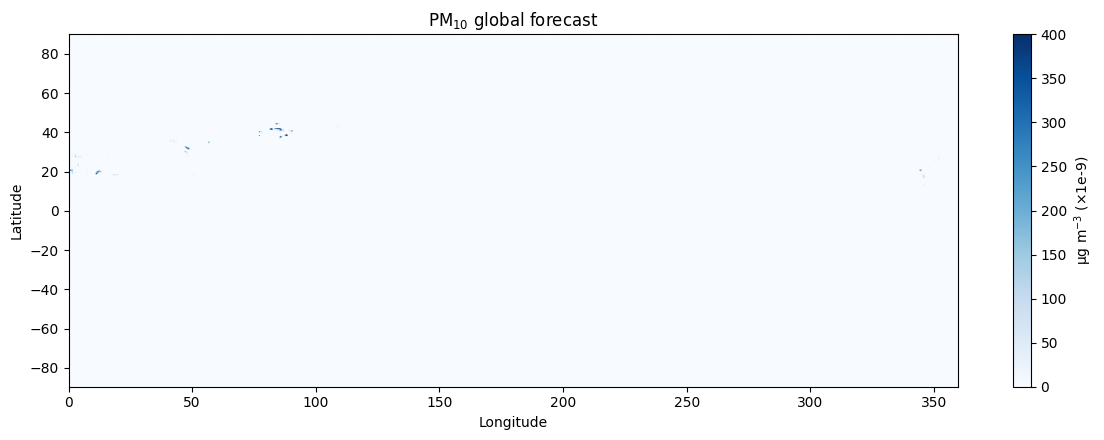

In [ ]:
#####################################
#  --- Aurora tiled global PM10 (CPU) — no feather/weighted blending ----------- #
# smaller variable set #
#####################################

import pickle, gc
from pathlib import Path

import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pandas as pd
import xarray as xr

from aurora import Batch, Metadata, AuroraAirPollution, AuroraPretrained, AuroraSmall

# ------------------ config / paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2022-06-11-cams-surface-level.nc"
atmo_path = download_path / "2022-06-11-cams-atmospheric.nc"
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ open datasets ------------------
surf_ds = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_ds = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)

# use analysis product; keep both time steps (00Z, 12Z)
if "forecast_period" in surf_ds.dims: surf_ds = surf_ds.isel(forecast_period=0)
if "forecast_period" in atmo_ds.dims: atmo_ds = atmo_ds.isel(forecast_period=0)

# ------------------ build model ------------------
model = AuroraAirPollution()
model.load_checkpoint()
model.eval()
ps = int(model.patch_size)
print("patch_size:", ps)

# ------------------ sizes & crop to multiples of patch size ------------------
lat_len = surf_ds.sizes["latitude"]
lon_len = surf_ds.sizes["longitude"]
H = (lat_len // ps) * ps
W = (lon_len // ps) * ps
print(f"Original dataset size (HxW): {lat_len} x {lon_len}")
print(f"Global working size (HxW): {H} x {W}")

surf_ds = surf_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
atmo_ds = atmo_ds.isel(latitude=slice(0, H), longitude=slice(0, W))

lat_vec_full = atmo_ds.latitude.values
lon_vec_full = atmo_ds.longitude.values

# ------------------ tiling parameters ------------------
tile   = 12 * ps         # tile height/width
overlap = 2 * ps         # still define overlap for stride; no feathering used
step   = tile - overlap  # stride

# simple canvas to paste tiles (no weighted accumulation)
canvas = np.full((H, W), np.nan, dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

# ------------------ run tiled inference (no blending) ------------------
gc.collect(); torch.cuda.empty_cache()

for i in range(0, H, step):
    for j in range(0, W, step):
        hi = min(i + tile, H)
        wi = min(j + tile, W)
        # force each side to be a multiple of ps
        h = (hi - i) // ps * ps
        w = (wi - j) // ps * ps
        if h < ps or w < ps:
            continue
        ii = slice(i, i + h)
        jj = slice(j, j + w)

        # build tile datasets
        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)
        static_vars_tile = {k: subset_static_tile(v, ii, jj) for k, v in static_vars_full.items()}

        surf_vars = {
            "2t":    torch.from_numpy(surf_t["t2m" ].values[None]),
            # "10u":   torch.from_numpy(surf_t["u10" ].values[None]),
            # "10v":   torch.from_numpy(surf_t["v10" ].values[None]),
            "msl":   torch.from_numpy(surf_t["msl" ].values[None]),
            # "pm1":   torch.from_numpy(surf_t["pm1" ].values[None]),
            # "pm2p5": torch.from_numpy(surf_t["pm2p5"].values[None]),
            "pm10":  torch.from_numpy(surf_t["pm10"].values[None]),
            # "tcco":  torch.from_numpy(surf_t["tcco"].values[None]),
            # "tc_no": torch.from_numpy(surf_t["tc_no"].values[None]),
            # "tcno2": torch.from_numpy(surf_t["tcno2"].values[None]),
            # "gtco3": torch.from_numpy(surf_t["gtco3"].values[None]),
            # "tcso2": torch.from_numpy(surf_t["tcso2"].values[None]),
        }
        atmos_vars = {
            "t":   torch.from_numpy(atmo_t["t" ].values[None]),
            # "u":   torch.from_numpy(atmo_t["u" ].values[None]),
            # "v":   torch.from_numpy(atmo_t["v" ].values[None]),
            "q":   torch.from_numpy(atmo_t["q" ].values[None]),
            # "z":   torch.from_numpy(atmo_t["z" ].values[None]),
            # "co":  torch.from_numpy(atmo_t["co"].values[None]),
            # "no":  torch.from_numpy(atmo_t["no"].values[None]),
            # "no2": torch.from_numpy(atmo_t["no2"].values[None]),
            # "go3": torch.from_numpy(atmo_t["go3"].values[None]),
            "so2": torch.from_numpy(atmo_t["so2"].values[None]),
        }

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=torch.from_numpy(atmo_t.latitude.values),
                lon=torch.from_numpy(atmo_t.longitude.values),
                time=tuple(atmo_t.valid_time.values.astype("datetime64[s]").astype(object)),
                atmos_levels=tuple(int(x) for x in atmo_t.pressure_level.values),
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)

        # paste directly into the canvas (no weighting / feathering)
        canvas[ii, jj] = tile_pm10

        # free
        del surf_t, atmo_t, static_vars_tile, batch_tile, pred_t, tile_pm10
        gc.collect()

# ------------------ plot stitched map ------------------
pm10_disp = canvas / 1e-9  # µg m^-3 (×1e-9), for display

lat_plot = lat_vec_full.copy()
if lat_plot[0] > lat_plot[-1]:
    lat_plot = lat_plot[::-1]
    pm10_disp = pm10_disp[::-1, :]

extent = [lon_vec_full.min(), lon_vec_full.max(), lat_plot.min(), lat_plot.max()]

finite = np.isfinite(pm10_disp)
vmin, vmax = np.percentile(pm10_disp[finite], [5, 95])  # or fix to (0,400) if you prefer

plt.figure(figsize=(12, 4.5))
plt.imshow(pm10_disp, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("PM$_{10}$ global forecast")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$ (×1e-9)")
plt.tight_layout()
plt.show()

# printing 
try:
    # CAMS files usually have valid_time; take the first step used in tiles
    sel_time = pd.to_datetime(atmo_ds.valid_time.values[0]).to_pydatetime()
except Exception:
    sel_time = None

# 2) Use the same orientation as the plot
#    (you already flipped pm10_disp if latitude was decreasing)
lat_for_df = lat_plot.copy()        # 1D
lon_for_df = lon_vec_full.copy()    # 1D
pm10_ugm3  = pm10_disp.copy()       # 2D, µg m^-3

# 3) Make 2D lon/lat grids that match the image
LON2D, LAT2D = np.meshgrid(lon_for_df, lat_for_df)

# 4) Flatten to a tidy table and drop NaNs
df_pred = pd.DataFrame({
    "latitude":  LAT2D.ravel(),
    "longitude": LON2D.ravel(),
    "pm10_ug_m3": pm10_ugm3.ravel(),   # predicted PM10 in µg m^-3
})
if sel_time is not None:
    df_pred.insert(0, "time", sel_time)  # same timestamp for all rows

df_pred = df_pred[np.isfinite(df_pred["pm10_ug_m3"])].reset_index(drop=True)

# 5) Print a quick summary and a few rows
print(f"\nPredicted PM10 table shape: {df_pred.shape} (rows, cols)")
print(df_pred.head(50))

# # 6) (Optional) Save to CSV and NetCDF
df_pred.to_csv("predictions/pm10_prediction_table.csv", index=False)
print("Saved CSV: pm10_prediction_table.csv")

# For the figure you plotted (same orientation as the image)
print("Longitude: min =", float(lon_vec_full.min()),
      "max =", float(lon_vec_full.max()),
      "unique =", len(np.unique(lon_vec_full)))

print("Latitude:  min =", float(lat_plot.min()),
      "max =", float(lat_plot.max()),
      "unique =", len(np.unique(lat_plot)))

print("DF longitude: min =", df_pred["longitude"].min(),
      "max =", df_pred["longitude"].max(),
      "unique =", df_pred["longitude"].nunique())

print("DF latitude:  min =", df_pred["latitude"].min(),
      "max =", df_pred["latitude"].max(),
      "unique =", df_pred["latitude"].nunique())

print("CAMS surface lon range:", float(surf_ds.longitude.min().values),
      "to", float(surf_ds.longitude.max().values),
      "| unique =", surf_ds.sizes["longitude"])

print("CAMS surface lat range:", float(surf_ds.latitude.min().values),
      "to", float(surf_ds.latitude.max().values),
      "| unique =", surf_ds.sizes["latitude"])

# Use the raw canvas (kg/m^3) or pm10_disp (µg/m^3) — choose ONE
arr = canvas              # kg/m^3

finite = np.isfinite(arr)
vals   = arr[finite]

print("PM10 — finite count:", vals.size)
print("PM10 — min:", float(vals.min()) if vals.size else None,
      "max:", float(vals.max()) if vals.size else None)

# Unique values (can be large!)
u = np.unique(vals)
print("PM10 — unique count:", u.size)

# Print a small preview
print("PM10 — first 10 unique values:", u[:10])

finite = np.isfinite(df_pred["pm10_ugm3"])
print("DF pm10 — finite count:", finite.sum())
print("DF pm10 — min:", df_pred.loc[finite, "pm10_ugm3"].min(),
      "max:", df_pred.loc[finite, "pm10_ugm3"].max())

# Unique values (may be huge)
u = df_pred.loc[finite, "pm10_ugm3"].unique()
print("DF pm10 — unique count:", u.size)
print("DF pm10 — first 10 unique values:", np.sort(u)[:10])


/tmp/ipykernel_1151135/919620282.py:22: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)  # may contain many channels


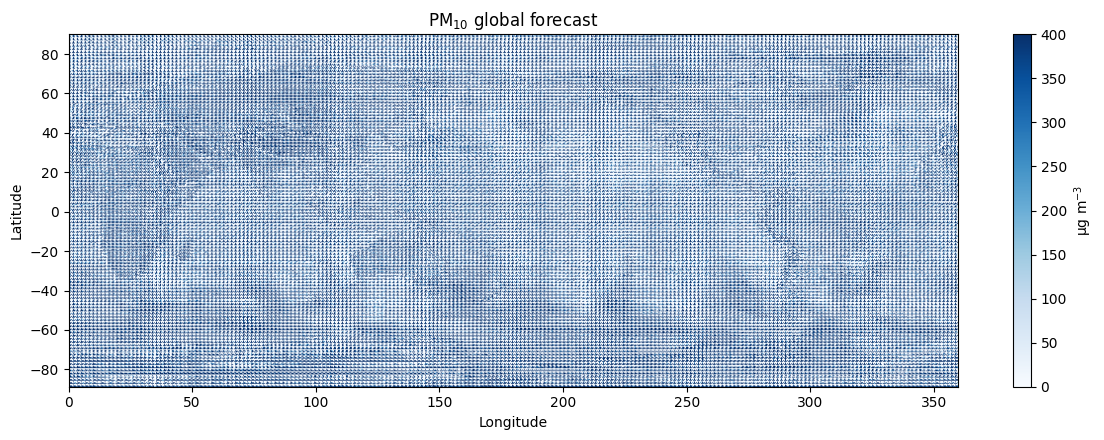

In [ ]:
# --- Aurora tiled global PM10 (CPU) — safe tiling + pm10 head -----------------
import pickle, gc
from pathlib import Path

import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pandas as pd
import xarray as xr

from aurora import Batch, Metadata, AuroraSmall
from aurora.normalisation import locations, scales

# ------------------ config / paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2022-06-11-cams-surface-level.nc"
atmo_path = download_path / "2022-06-11-cams-atmospheric.nc"
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)  # may contain many channels

# ------------------ open datasets ------------------
surf_ds = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_ds = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)

# Use analysis product; keep both time steps (00Z, 12Z)
if "forecast_period" in surf_ds.dims:
    surf_ds = surf_ds.isel(forecast_period=0)
if "forecast_period" in atmo_ds.dims:
    atmo_ds = atmo_ds.isel(forecast_period=0)

# ------------------ choose variables ------------------
# Model-side variable sets we want to use
SURF_VARS   = ("2t", "msl", "pm10")  # add pm10
STATIC_VARS = ("lsm", "z", "slt")
ATMOS_VARS  = ("t", "q")

# Map model names -> dataset variable names
surf_name_map = {
    "2t":  "t2m",
    "msl": "msl",
    "pm10":"pm10",
}
atmo_name_map = {
    "t": "t",
    "q": "q",
}

# ------------------ build model (AuroraSmall) ------------------
model = AuroraSmall(
    surf_vars=SURF_VARS,
    static_vars=STATIC_VARS,
    atmos_vars=ATMOS_VARS,
    stabilise_level_agg=True,
)
# Register normalization for pm10 from this file's stats (rough but works)
pm10_vals = surf_ds["pm10"].values
pm10_mean = float(np.nanmean(pm10_vals))
pm10_std  = float(np.nanstd(pm10_vals) + 1e-6)
locations["pm10"] = pm10_mean
scales["pm10"]    = pm10_std

# Load small checkpoint; allow missing/unmatched keys (new pm10 head etc.)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-small-pretrained.ckpt", strict=False)
model.eval()

# Zero-init the new pm10 token embedding if it exists (not in the ckpt)
with torch.no_grad():
    if hasattr(model.encoder, "surf_token_embeds") and \
       "pm10" in model.encoder.surf_token_embeds.weights:
        model.encoder.surf_token_embeds.weights["pm10"].zero_()

ps = int(model.patch_size)

# ------------------ sizes & crop to multiples of patch size ------------------
lat_len = surf_ds.sizes["latitude"]
lon_len = surf_ds.sizes["longitude"]
H = (lat_len // ps) * ps
W = (lon_len // ps) * ps
surf_ds = surf_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
atmo_ds = atmo_ds.isel(latitude=slice(0, H), longitude=slice(0, W))

lat_vec_full = atmo_ds.latitude.values
lon_vec_full = atmo_ds.longitude.values

# ------------------ tiling parameters (no tiny edge tiles) -------------------
tile    = 12 * ps          # 12x12 patches per tile
overlap = 2 * ps
step    = tile - overlap

canvas = np.full((H, W), np.nan, dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

## Anchor last tiles to the borders so every tile is exactly (tile x tile)
i_vals = list(range(0, max(H - tile, 0) + 1, step))
if (H - tile) % step != 0:
    i_vals.append(H - tile)

j_vals = list(range(0, max(W - tile, 0) + 1, step))
if (W - tile) % step != 0:
    j_vals.append(W - tile)

# ------------------ run tiled inference (no blending) ------------------------
gc.collect(); torch.cuda.empty_cache()

for i0 in i_vals:
    for j0 in j_vals:
        ii = slice(i0, i0 + tile)
        jj = slice(j0, j0 + tile)

        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)

        # Filter static vars strictly to what the model expects
        static_vars_tile = {
            k: subset_static_tile(v, ii, jj)
            for k, v in static_vars_full.items()
            if k in STATIC_VARS
        }

        # Build surf/atmos dicts from the chosen names
        surf_vars = {
            k: torch.from_numpy(surf_t[surf_name_map[k]].values[None])
            for k in SURF_VARS
        }
        atmos_vars = {
            k: torch.from_numpy(atmo_t[atmo_name_map[k]].values[None])
            for k in ATMOS_VARS
        }

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=torch.from_numpy(atmo_t.latitude.values),
                lon=torch.from_numpy(atmo_t.longitude.values),
                time=tuple(atmo_t.valid_time.values.astype("datetime64[s]").astype(object)),
                atmos_levels=tuple(int(x) for x in atmo_t.pressure_level.values),
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        # pm10 head exists because we added it to SURF_VARS (random/zero init if not in ckpt)
        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)
        canvas[ii, jj] = tile_pm10

        del surf_t, atmo_t, static_vars_tile, batch_tile, pred_t
        gc.collect()

# ------------------ plot stitched map ------------------
pm10_disp = canvas / 1e-9  # convert to µg m^-3 if inputs are kg m^-3

lat_plot = lat_vec_full.copy()
if lat_plot[0] > lat_plot[-1]:
    lat_plot = lat_plot[::-1]
    pm10_disp = pm10_disp[::-1, :]

extent = [lon_vec_full.min(), lon_vec_full.max(), lat_plot.min(), lat_plot.max()]

plt.figure(figsize=(12, 4.5))
plt.imshow(pm10_disp, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("PM$_{10}$ global forecast")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$")
plt.tight_layout()
plt.show()

# printing 
try:
    # CAMS files usually have valid_time; take the first step used in tiles
    sel_time = pd.to_datetime(atmo_ds.valid_time.values[0]).to_pydatetime()
except Exception:
    sel_time = None

# 2) Use the same orientation as the plot
#    (you already flipped pm10_disp if latitude was decreasing)
lat_for_df = lat_plot.copy()        # 1D
lon_for_df = lon_vec_full.copy()    # 1D
pm10_ugm3  = pm10_disp.copy()       # 2D, µg m^-3

# 3) Make 2D lon/lat grids that match the image
LON2D, LAT2D = np.meshgrid(lon_for_df, lat_for_df)

# 4) Flatten to a tidy table and drop NaNs
df_pred = pd.DataFrame({
    "latitude":  LAT2D.ravel(),
    "longitude": LON2D.ravel(),
    "pm10_ug_m3": pm10_ugm3.ravel(),   # predicted PM10 in µg m^-3
})
if sel_time is not None:
    df_pred.insert(0, "time", sel_time)  # same timestamp for all rows

df_pred = df_pred[np.isfinite(df_pred["pm10_ug_m3"])].reset_index(drop=True)

# 5) Print a quick summary and a few rows
print(f"\nPredicted PM10 table shape: {df_pred.shape} (rows, cols)")
print(df_pred.head(50))

# # 6) (Optional) Save to CSV and NetCDF
df_pred.to_csv("predictions/pm10_prediction_table.csv", index=False)
print("Saved CSV: pm10_prediction_table.csv")

# For the figure you plotted (same orientation as the image)
print("Longitude: min =", float(lon_vec_full.min()),
      "max =", float(lon_vec_full.max()),
      "unique =", len(np.unique(lon_vec_full)))

print("Latitude:  min =", float(lat_plot.min()),
      "max =", float(lat_plot.max()),
      "unique =", len(np.unique(lat_plot)))

print("DF longitude: min =", df_pred["longitude"].min(),
      "max =", df_pred["longitude"].max(),
      "unique =", df_pred["longitude"].nunique())

print("DF latitude:  min =", df_pred["latitude"].min(),
      "max =", df_pred["latitude"].max(),
      "unique =", df_pred["latitude"].nunique())

print("CAMS surface lon range:", float(surf_ds.longitude.min().values),
      "to", float(surf_ds.longitude.max().values),
      "| unique =", surf_ds.sizes["longitude"])

print("CAMS surface lat range:", float(surf_ds.latitude.min().values),
      "to", float(surf_ds.latitude.max().values),
      "| unique =", surf_ds.sizes["latitude"])

# Use the raw canvas (kg/m^3) or pm10_disp (µg/m^3) — choose ONE
arr = canvas              # kg/m^3

finite = np.isfinite(arr)
vals   = arr[finite]

print("PM10 — finite count:", vals.size)
print("PM10 — min:", float(vals.min()) if vals.size else None,
      "max:", float(vals.max()) if vals.size else None)

# Unique values (can be large!)
u = np.unique(vals)
print("PM10 — unique count:", u.size)

# Print a small preview
print("PM10 — first 10 unique values:", u[:10])

finite = np.isfinite(df_pred["pm10_ugm3"])
print("DF pm10 — finite count:", finite.sum())
print("DF pm10 — min:", df_pred.loc[finite, "pm10_ugm3"].min(),
      "max:", df_pred.loc[finite, "pm10_ugm3"].max())

# Unique values (may be huge)
u = df_pred.loc[finite, "pm10_ugm3"].unique()
print("DF pm10 — unique count:", u.size)
print("DF pm10 — first 10 unique values:", np.sort(u)[:10])


/tmp/ipykernel_4098652/1782132840.py:191: RuntimeWarning: Mean of empty slice
  locations["pm10"] = float(np.nanmean(pm10_vals)) if pm10_vals.size else 0.0
/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


patch_size: 4


/tmp/ipykernel_4098652/1782132840.py:342: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(pm10_disp, extent=extent, origin="lower",
/tmp/ipykernel_4098652/1782132840.py:342: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(pm10_disp, extent=extent, origin="lower",


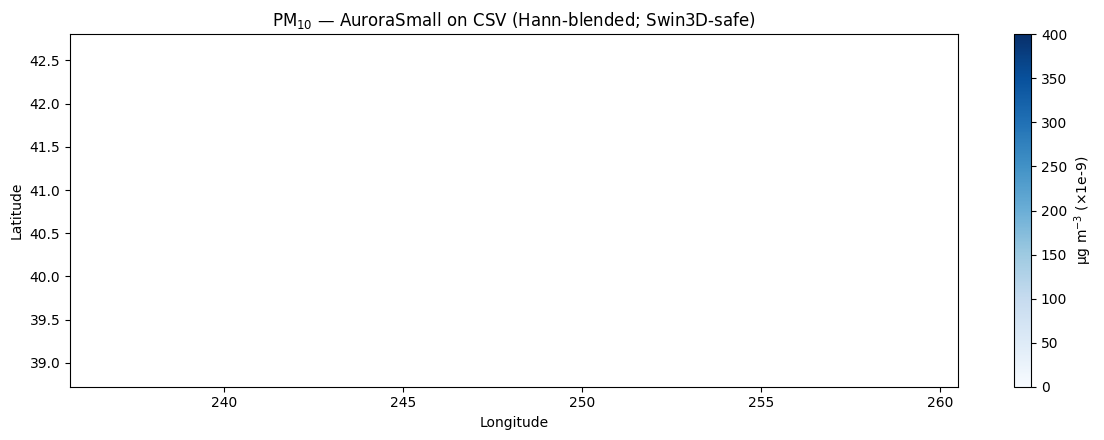

In [ ]:
###############################################
# AuroraSmall on a single CSV (Hann-blended tiles; robust for Swin3D)
# - Reads CSV (lat/lon/vars), converts lon to [0,360)
# - Builds regular grid, NN-upsamples to >= 8*ps & multiples of ps
# - Uses static vars from HF pickle (lsm/z/slt)
# - Adds pm10 head for AuroraSmall
# - Strictly monotonic Metadata (lat dec, lon inc) with Python datetimes
###############################################

import gc
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pandas as pd
import xarray as xr

from aurora import Batch, Metadata, AuroraSmall
from aurora.normalisation import locations, scales

# ------------------ config / paths ------------------
csv_path    = Path("/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/files/ebus_min_2024_12.csv")
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ small helpers ------------------
def pick_col(df, candidate_names):
    lower_to_orig = {c.lower(): c for c in df.columns}
    for name in candidate_names:
        if name.lower() in lower_to_orig:
            return lower_to_orig[name.lower()]
    return None

def rasterise(df, series, lat_col, lon_col, lats_sorted, lons_sorted, complete_grid):
    H0, W0 = len(lats_sorted), len(lons_sorted)
    if complete_grid:
        df_sorted = df.sort_values([lat_col, lon_col], kind="mergesort")
        arr = df_sorted[series.name].to_numpy().reshape(H0, W0)
        return arr.astype(np.float32)
    # Nearest-bin fill
    arr = np.full((H0, W0), np.nan, dtype=np.float32)
    for (_, row), val in zip(df.iterrows(), series.values):
        i = int(np.searchsorted(lats_sorted, row[lat_col], side="left"))
        j = int(np.searchsorted(lons_sorted, row[lon_col], side="left"))
        i = max(0, min(H0 - 1, i))
        j = max(0, min(W0 - 1, j))
        arr[i, j] = np.float32(val)
    return arr

def target_size(n, ps, min_tiles):
    # Upsample to at least min_tiles * ps, rounded up to multiple of ps
    return int(np.ceil(max(n, min_tiles*ps) / ps) * ps)

def nn_resample(arr, lats_src, lons_src, Ht, Wt):
    i_idx = np.rint(np.linspace(0, len(lats_src) - 1, Ht)).astype(int)
    j_idx = np.rint(np.linspace(0, len(lons_src) - 1, Wt)).astype(int)
    i_idx = np.clip(i_idx, 0, len(lats_src) - 1)
    j_idx = np.clip(j_idx, 0, len(lons_src) - 1)
    return arr[np.ix_(i_idx, j_idx)], lats_src[i_idx], lons_src[j_idx]

def flip_like(arr, flip_lat=False, flip_lon=False):
    a = arr
    if flip_lat:
        if a.ndim == 2:   a = a[::-1, :]
        elif a.ndim == 3: a = a[:, ::-1, :]
        elif a.ndim == 5: a = a[:, :, :, ::-1, :]
    if flip_lon:
        if a.ndim == 2:   a = a[:, ::-1]
        elif a.ndim == 3: a = a[:, :, ::-1]
        elif a.ndim == 5: a = a[:, :, :, :, ::-1]
    return a.copy()  # ensure positive strides

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ load CSV ------------------
df = pd.read_csv(csv_path)

# Column aliases (case-insensitive)
aliases = {
    "latitude":  ["lat", "latitude"],
    "longitude": ["lon", "longitude"],
    "t2m":  ["tt", "t2m", "2t"],
    "msl":  ["sp", "msl", "psl", "mslp"],
    "pm10": ["pm10", "pm_10"],
    "t": ["tt", "t", "ta"],
    "q": ["trh", "q", "hus", "qair"],
}

lat_col = pick_col(df, aliases["latitude"])
lon_col = pick_col(df, aliases["longitude"])


# Convert longitudes to [0,360)
df[lon_col] = np.mod(df[lon_col].astype(float), 360.0)

# Time (make sure we pass Python datetime, not numpy.datetime64)
time_col = pick_col(df, ["time", "valid_time", "datetime", "date", "times"])
snapshot_time = None
if time_col:
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    t0 = df[time_col].dropna().min()
    if pd.notna(t0):
        df = df.loc[df[time_col] == t0].copy()
        snapshot_time = pd.Timestamp(t0).to_pydatetime()
if snapshot_time is None:
    snapshot_time = pd.Timestamp("1970-01-01T00:00:00").to_pydatetime()
time_tuple = (snapshot_time,)

# Map available columns
map_cols = {}
for k in ["t2m", "msl", "pm10", "t", "q"]:
    c = pick_col(df, aliases[k])
    if c is not None:
        map_cols[k] = c

# ------------------ native grid from CSV ------------------
lats_raw = np.sort(df[lat_col].unique())   # increasing
lons_raw = np.sort(df[lon_col].unique())   # increasing in [0,360)
H0, W0 = len(lats_raw), len(lons_raw)
assert H0 > 0 and W0 > 0, "No unique lat/lon values found."
complete_grid = (H0 * W0 == len(df))

surf_needed = ["t2m", "msl", "pm10"]
atmo_needed = ["t", "q"]

surf_native = {}
for k in surf_needed:
    if k in map_cols:
        vals = rasterise(df, df[map_cols[k]].rename(map_cols[k]),
                         lat_col, lon_col, lats_raw, lons_raw, complete_grid)
    else:
        vals = np.zeros((H0, W0), dtype=np.float32)
    surf_native[k] = xr.DataArray(vals, dims=("latitude", "longitude"))

atmo_native = {}
for k in atmo_needed:
    if k in map_cols:
        vals = rasterise(df, df[map_cols[k]].rename(map_cols[k]),
                         lat_col, lon_col, lats_raw, lons_raw, complete_grid)
        atmo_native[k] = xr.DataArray(vals, dims=("latitude", "longitude"))

surf_native = xr.Dataset(surf_native, coords={"latitude": lats_raw, "longitude": lons_raw})
atmo_native = xr.Dataset(atmo_native, coords={"latitude": lats_raw, "longitude": lons_raw})

# ------------------ probe patch size ------------------
probe = AuroraSmall(
    surf_vars=("2t","msl","pm10"),
    static_vars=("lsm","z","slt"),
    atmos_vars=tuple(atmo_native.data_vars.keys()) if len(atmo_native.data_vars) > 0 else ("t",),
    stabilise_level_agg=True
)
ps = int(probe.patch_size)
del probe

# ------------------ upsample to satisfy Swin3D (>= 8 patches/side) ----------
MIN_TILES = 8  # <<< important: at least 8x8 patches spatially
Ht = target_size(H0, ps, min_tiles=MIN_TILES)
Wt = target_size(W0, ps, min_tiles=MIN_TILES)

surf_up = {}
for k, da in surf_native.data_vars.items():
    up, lats_up, lons_up = nn_resample(da.values, surf_native.latitude.values, surf_native.longitude.values, Ht, Wt)
    surf_up[k] = xr.DataArray(up.astype(np.float32), dims=("latitude", "longitude"))
surf_ds = xr.Dataset(surf_up, coords={"latitude": lats_up, "longitude": lons_up})

atmo_up = {}
for k, da in atmo_native.data_vars.items():
    up, _, _ = nn_resample(da.values, atmo_native.latitude.values, atmo_native.longitude.values, Ht, Wt)
    atmo_up[k] = xr.DataArray(up.astype(np.float32), dims=("latitude", "longitude"))
atmo_ds = xr.Dataset(atmo_up, coords={"latitude": lats_up, "longitude": lons_up})

# ------------------ model variable sets ------------------
SURF_VARS   = ("2t", "msl", "pm10")
ATMOS_VARS  = tuple([k for k in ["t", "q"] if k in atmo_ds]) if len(atmo_ds.data_vars) > 0 else ("t",)
STATIC_VARS = ("lsm", "z", "slt")

# ------------------ build model ------------------
model = AuroraSmall(
    surf_vars=SURF_VARS,
    static_vars=STATIC_VARS,
    atmos_vars=ATMOS_VARS,
    stabilise_level_agg=True,
)

# ------------------ normalisation ------------------
pm10_vals = surf_ds["pm10"].values if "pm10" in surf_ds else np.zeros((Ht, Wt))
locations["pm10"] = float(np.nanmean(pm10_vals)) if pm10_vals.size else 0.0
scales["pm10"]    = float(np.nanstd(pm10_vals) + 1e-6) if pm10_vals.size else 1.0

if "t2m" in surf_ds and not np.allclose(surf_ds["t2m"].values, 0):
    locations["2t"] = float(np.nanmean(surf_ds["t2m"].values))
    scales["2t"]    = float(np.nanstd(surf_ds["t2m"].values) + 1e-6)
else:
    locations["2t"] = 0.0; scales["2t"] = 1.0

if "msl" in surf_ds and not np.allclose(surf_ds["msl"].values, 0):
    locations["msl"] = float(np.nanmean(surf_ds["msl"].values))
    scales["msl"]    = float(np.nanstd(surf_ds["msl"].values) + 1e-6)
else:
    locations["msl"] = 0.0; scales["msl"] = 1.0

# ------------------ weights & model init ------------------
model.load_checkpoint("microsoft/aurora", "aurora-0.25-small-pretrained.ckpt", strict=False)
model.eval()
with torch.no_grad():
    if hasattr(model.encoder, "surf_token_embeds") and "pm10" in model.encoder.surf_token_embeds.weights:
        model.encoder.surf_token_embeds.weights["pm10"].zero_()

print("patch_size:", ps)
H, W = Ht, Wt
lat_vec_full = surf_ds.latitude.values
lon_vec_full = surf_ds.longitude.values

# ------------------ tiling + Hann blending ------------------
tile    = min(12 * ps, H, W)
tile    = max(tile, 8 * ps)          # <<< important: at least 8x8 patches per tile
tile    = (tile // ps) * ps
overlap = 2 * ps
step    = max(ps, tile - overlap)

def tile_starts(L, tile, step):
    starts = [0]
    while starts[-1] + tile < L:
        nxt = starts[-1] + step
        if nxt + tile >= L:
            nxt = L - tile
        if nxt == starts[-1]:
            break
        starts.append(nxt)
    return sorted(set(starts))

row_starts = tile_starts(H, tile, step)
col_starts = tile_starts(W, tile, step)

accum  = np.zeros((H, W), dtype=np.float32)
weight = np.zeros((H, W), dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

surf_name_map = {"2t": "t2m", "msl": "msl", "pm10": "pm10"}

wy_full = np.hanning(tile).astype(np.float32)
wx_full = np.hanning(tile).astype(np.float32)
w2d_full = (wy_full[:, None] * wx_full[None, :]).astype(np.float32)

gc.collect(); torch.cuda.empty_cache()

for i0 in row_starts:
    for j0 in col_starts:
        ii = slice(i0, i0 + tile)
        jj = slice(j0, j0 + tile)

        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)

        static_vars_tile = {
            k: subset_static_tile(v, ii, jj)
            for k, v in static_vars_full.items()
            if k in ("lsm", "z", "slt")
        }

        # Surf tensors as (B=1, T=1, H, W)
        surf_vars_np = {}
        for k in SURF_VARS:
            ds_key = surf_name_map[k]
            if ds_key in surf_t:
                base = surf_t[ds_key].values.astype(np.float32)         # (H,W)
                arr  = base[None, None, :, :]                            # (1,1,H,W)
            else:
                arr  = np.zeros((1, 1, tile, tile), dtype=np.float32)
            surf_vars_np[k] = arr

        # Atmos tensors as (1,1,1,H,W) per var, or dummy if none
        atmos_vars_np = {}
        if len(atmo_t.data_vars) > 0:
            for k in atmo_t.data_vars:
                base = atmo_t[k].values.astype(np.float32)
                arr5 = base[None, None, None, :, :]                      # (1,1,1,H,W)
                atmos_vars_np[k] = arr5
        else:
            atmos_vars_np["t"] = np.zeros((1, 1, 1, tile, tile), dtype=np.float32)

        # Orient to match metadata ordering (lat dec, lon inc)
        flip_lat = True   # xarray lat is inc
        flip_lon = False
        for k in list(surf_vars_np.keys()):
            surf_vars_np[k] = flip_like(surf_vars_np[k], flip_lat=flip_lat, flip_lon=flip_lon)
        for k in list(atmos_vars_np.keys()):
            atmos_vars_np[k] = flip_like(atmos_vars_np[k], flip_lat=flip_lat, flip_lon=flip_lon)
        for k in list(static_vars_tile.keys()):
            static_vars_tile[k] = flip_like(np.asarray(static_vars_tile[k]),
                                            flip_lat=flip_lat, flip_lon=flip_lon)

        # Synthetic, strictly monotonic metadata
        lat_meta = torch.linspace( 90.0, -90.0, tile, dtype=torch.float32)         # dec
        lon_meta = torch.linspace(  0.0, 360.0 - 1e-3, tile, dtype=torch.float32)  # inc

        # Tensors (contiguous)
        surf_vars  = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in surf_vars_np.items()}
        atmos_vars = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in atmos_vars_np.items()}
        static_tensors = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in static_vars_tile.items()}

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars=static_tensors,
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=lat_meta,
                lon=lon_meta,
                time=time_tuple,          # Python datetime(s)
                atmos_levels=(1000,),     # single dummy level
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)
        accum[ii, jj]  += tile_pm10 * w2d_full
        weight[ii, jj] += w2d_full

        del surf_t, atmo_t, static_vars_tile, static_tensors, batch_tile, pred_t, tile_pm10
        gc.collect()

# ------------------ compose & plot ------------------
canvas = np.full((H, W), np.nan, dtype=np.float32)
np.divide(accum, np.maximum(weight, 1e-12), out=canvas, where=weight > 0)

pm10_disp = canvas / 1e-9  # µg m^-3 if inputs were kg m^-3
extent = [lon_vec_full.min(), lon_vec_full.max(), lat_vec_full.min(), lat_vec_full.max()]

plt.figure(figsize=(12, 4.5))
plt.imshow(pm10_disp, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("PM$_{10}$ — AuroraSmall on CSV (Hann-blended; Swin3D-safe)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$ (×1e-9)")
plt.tight_layout()
plt.show()

# printing 
try:
    # CAMS files usually have valid_time; take the first step used in tiles
    sel_time = pd.to_datetime(atmo_ds.valid_time.values[0]).to_pydatetime()
except Exception:
    sel_time = None

# 2) Use the same orientation as the plot
#    (you already flipped pm10_disp if latitude was decreasing)
lat_for_df = lat_plot.copy()        # 1D
lon_for_df = lon_vec_full.copy()    # 1D
pm10_ugm3  = pm10_disp.copy()       # 2D, µg m^-3

# 3) Make 2D lon/lat grids that match the image
LON2D, LAT2D = np.meshgrid(lon_for_df, lat_for_df)

# 4) Flatten to a tidy table and drop NaNs
df_pred = pd.DataFrame({
    "latitude":  LAT2D.ravel(),
    "longitude": LON2D.ravel(),
    "pm10_ug_m3": pm10_ugm3.ravel(),   # predicted PM10 in µg m^-3
})
if sel_time is not None:
    df_pred.insert(0, "time", sel_time)  # same timestamp for all rows

df_pred = df_pred[np.isfinite(df_pred["pm10_ug_m3"])].reset_index(drop=True)

# 5) Print a quick summary and a few rows
print(f"\nPredicted PM10 table shape: {df_pred.shape} (rows, cols)")
print(df_pred.head(50))

# # 6) (Optional) Save to CSV and NetCDF
df_pred.to_csv("predictions/pm10_prediction_table.csv", index=False)
print("Saved CSV: pm10_prediction_table.csv")

# For the figure you plotted (same orientation as the image)
print("Longitude: min =", float(lon_vec_full.min()),
      "max =", float(lon_vec_full.max()),
      "unique =", len(np.unique(lon_vec_full)))

print("Latitude:  min =", float(lat_plot.min()),
      "max =", float(lat_plot.max()),
      "unique =", len(np.unique(lat_plot)))

print("DF longitude: min =", df_pred["longitude"].min(),
      "max =", df_pred["longitude"].max(),
      "unique =", df_pred["longitude"].nunique())

print("DF latitude:  min =", df_pred["latitude"].min(),
      "max =", df_pred["latitude"].max(),
      "unique =", df_pred["latitude"].nunique())

print("CAMS surface lon range:", float(surf_ds.longitude.min().values),
      "to", float(surf_ds.longitude.max().values),
      "| unique =", surf_ds.sizes["longitude"])

print("CAMS surface lat range:", float(surf_ds.latitude.min().values),
      "to", float(surf_ds.latitude.max().values),
      "| unique =", surf_ds.sizes["latitude"])

# Use the raw canvas (kg/m^3) or pm10_disp (µg/m^3) — choose ONE
arr = canvas              # kg/m^3

finite = np.isfinite(arr)
vals   = arr[finite]

print("PM10 — finite count:", vals.size)
print("PM10 — min:", float(vals.min()) if vals.size else None,
      "max:", float(vals.max()) if vals.size else None)

# Unique values (can be large!)
u = np.unique(vals)
print("PM10 — unique count:", u.size)

# Print a small preview
print("PM10 — first 10 unique values:", u[:10])

finite = np.isfinite(df_pred["pm10_ugm3"])
print("DF pm10 — finite count:", finite.sum())
print("DF pm10 — min:", df_pred.loc[finite, "pm10_ugm3"].min(),
      "max:", df_pred.loc[finite, "pm10_ugm3"].max())

# Unique values (may be huge)
u = df_pred.loc[finite, "pm10_ugm3"].unique()
print("DF pm10 — unique count:", u.size)
print("DF pm10 — first 10 unique values:", np.sort(u)[:10])


In [11]:
print("canvas finite count:", np.isfinite(canvas).sum(), "of", canvas.size)
if "pm10" in surf_ds:
    raw = surf_ds["pm10"].values
    print("CSV pm10 finite count:", np.isfinite(raw).sum(), "of", raw.size,
          "| min:", np.nanmin(raw), "max:", np.nanmax(raw))
else:
    print("No 'pm10' column found in the CSV (after alias mapping).")


canvas finite count: 405000 of 405000
CSV pm10 finite count: 810000 of 810000 | min: 2.8063002e-25 max: 3.5693247e-06


/tmp/ipykernel_1468310/2557933469.py:85: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Selected timestamp: 2024-12-11 18:52:00  (rows: 19)
Raw PM10 grid: finite 10 of 342 | min: 7.5 max: 1257.7
Final plot array: finite 28 of 1024 | vmin: 8235000524.8 vmax: 1257699934208.0


/tmp/ipykernel_1468310/2557933469.py:352: UserWarning: AuroraSmall prediction empty/constant; showing CSV PM10.
  warnings.warn("AuroraSmall prediction empty/constant; showing CSV PM10.")


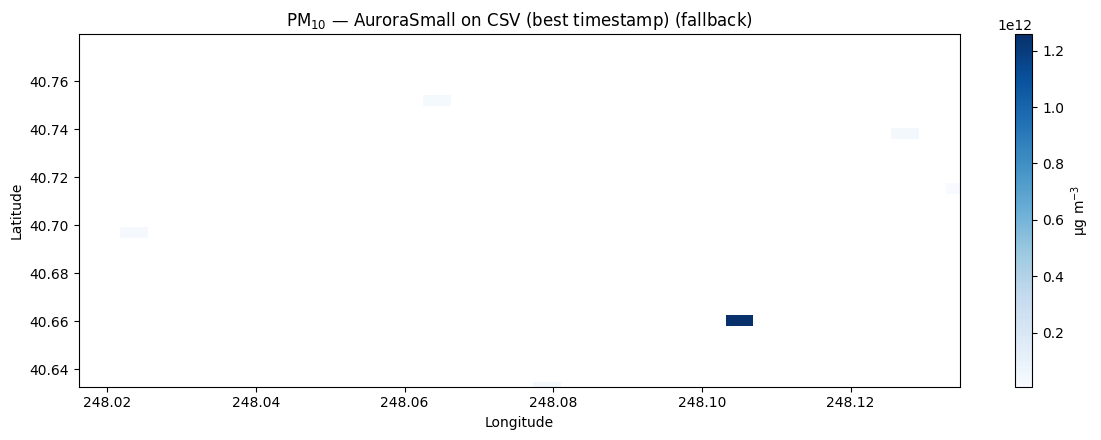

In [ ]:
###############################################
# AuroraSmall on CSV (robust time selection + Swin3D-safe + fallback)
# - Pick the timestamp with the MOST valid PM10 cells in the entire CSV
#   (tie-break: highest mean PM10; if PM10 absent, use PM2.5 to choose)
# - Build grid (nearest if scattered), upsample to ≥8*patch_size
# - Try AuroraSmall PM10; if empty/constant, show CSV PM10 instead
###############################################

import gc
import pickle
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pandas as pd
import xarray as xr

from aurora import Batch, Metadata, AuroraSmall
from aurora.normalisation import locations, scales

# ------------------ paths ------------------
CSV_PATH    = Path("/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/files/ebus_min_2024_12.csv")
STATIC_PATH = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ helpers ------------------
def pick_col(df, candidate_names):
    m = {c.lower(): c for c in df.columns}
    for name in candidate_names:
        if name.lower() in m:
            return m[name.lower()]
    return None

def rasterise(df_slice, series, lat_col, lon_col, lats_sorted, lons_sorted, complete_grid):
    """Make (H,W) array; reshape if complete grid else nearest-bin scatter."""
    H0, W0 = len(lats_sorted), len(lons_sorted)
    if complete_grid:
        s = df_slice.sort_values([lat_col, lon_col], kind="mergesort")
        arr = s[series.name].to_numpy().reshape(H0, W0)
        return arr.astype(np.float32)
    arr = np.full((H0, W0), np.nan, dtype=np.float32)
    for (_, row), val in zip(df_slice.iterrows(), series.values):
        i = int(np.searchsorted(lats_sorted, row[lat_col], side="left"))
        j = int(np.searchsorted(lons_sorted, row[lon_col], side="left"))
        i = max(0, min(H0 - 1, i)); j = max(0, min(W0 - 1, j))
        arr[i, j] = np.float32(val)
    return arr

def target_size(n, ps, min_tiles=8):
    return int(np.ceil(max(n, min_tiles*ps) / ps) * ps)

def nn_resample(arr, lats_src, lons_src, Ht, Wt):
    i_idx = np.rint(np.linspace(0, len(lats_src) - 1, Ht)).astype(int)
    j_idx = np.rint(np.linspace(0, len(lons_src) - 1, Wt)).astype(int)
    i_idx = np.clip(i_idx, 0, len(lats_src) - 1)
    j_idx = np.clip(j_idx, 0, len(lons_src) - 1)
    return arr[np.ix_(i_idx, j_idx)], lats_src[i_idx], lons_src[j_idx]

def flip_like(arr, flip_lat=False, flip_lon=False):
    a = arr
    if flip_lat:
        if a.ndim == 2:   a = a[::-1, :]
        elif a.ndim == 3: a = a[:, ::-1, :]
        elif a.ndim == 5: a = a[:, :, :, ::-1, :]
    if flip_lon:
        if a.ndim == 2:   a = a[:, ::-1]
        elif a.ndim == 3: a = a[:, :, ::-1]
        elif a.ndim == 5: a = a[:, :, :, :, ::-1]
    return a.copy()

def autoscale_limits(A):
    finite = np.isfinite(A)
    if not finite.any():
        return 0.0, 1.0
    lo, hi = np.percentile(A[finite], [5, 95])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        m = np.nanmean(A[finite])
        return float(m - 1.0), float(m + 1.0)
    return float(lo), float(hi)

# ------------------ static vars ------------------
with open(STATIC_PATH, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ load CSV ------------------
df = pd.read_csv(CSV_PATH)

aliases = {
    "latitude":  ["lat", "latitude"],
    "longitude": ["lon", "longitude"],
    "time":      ["times", "time", "valid_time", "datetime", "date"],

    # surface inputs we might have
    "t2m":  ["tt", "t2m", "2t"],
    "msl":  ["sp", "msl", "psl", "mslp"],
    "pm10": ["pm10", "pm_10"],
    "pm2p5":["pm2p5", "pm_2p5", "pm25", "pm2.5"],

    # optional atmos
    "t": ["tt", "t", "ta"],
    "q": ["trh", "q", "hus", "qair"],
}

lat_col  = pick_col(df, aliases["latitude"])
lon_col  = pick_col(df, aliases["longitude"])
time_col = pick_col(df, aliases["time"])
assert lat_col and lon_col and time_col, "Need latitude/longitude/time columns."

# Normalise coordinates + time
df[lon_col]  = np.mod(df[lon_col].astype(float), 360.0)
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).copy()

pm10_col = pick_col(df, aliases["pm10"])
pm25_col = pick_col(df, aliases["pm2p5"])

# ------------------ pick the "best" timestamp ------------------
# Strategy:
# 1) For every timestamp, compute count of finite PM10 values (after grouping).
# 2) Pick timestamp with max count; tie-break by highest mean PM10.
# 3) If PM10 entirely missing across all times, use PM2.5 to choose, then display PM2.5 as PM10 fallback.

grouped = df.groupby(df[time_col])
if pm10_col:
    stat = grouped[pm10_col].agg(['count', 'mean'])
    # 'count' here is row count; later, after gridding, we'll still have plenty of non-NaN.
    t_sel = stat.sort_values(['count', 'mean'], ascending=[False, False]).index[0]
else:
    assert pm25_col, "No PM10 or PM2.5 columns found."
    stat = grouped[pm25_col].agg(['count', 'mean'])
    t_sel = stat.sort_values(['count', 'mean'], ascending=[False, False]).index[0]

df_ts = df[df[time_col] == t_sel].copy()
snapshot_time = pd.Timestamp(t_sel).to_pydatetime()
time_tuple = (snapshot_time,)
print(f"Selected timestamp: {t_sel}  (rows: {len(df_ts)})")

# ------------------ map available columns ------------------
map_cols = {}
for k in ["t2m", "msl", "pm10", "pm2p5", "t", "q"]:
    c = pick_col(df_ts, aliases.get(k, []))
    if c is not None:
        map_cols[k] = c

# ------------------ grid from the selected timestamp ------------------
lats_raw = np.sort(df_ts[lat_col].unique())
lons_raw = np.sort(df_ts[lon_col].unique())
H0, W0 = len(lats_raw), len(lons_raw)
assert H0 > 0 and W0 > 0, "No unique lat/lon for the selected timestamp."
complete_grid = (H0 * W0 == len(df_ts))

def make_ds(keys):
    data = {}
    for k in keys:
        if k in map_cols:
            vals = rasterise(df_ts, df_ts[map_cols[k]].rename(map_cols[k]),
                             lat_col, lon_col, lats_raw, lons_raw, complete_grid)
            data[k] = xr.DataArray(vals, dims=("latitude", "longitude"))
    return xr.Dataset(data, coords={"latitude": lats_raw, "longitude": lons_raw})

surf_native = make_ds(["t2m", "msl", "pm10", "pm2p5"])
atmo_native = make_ds(["t", "q"])

# Diagnostics on raw PM10 grid
if "pm10" in surf_native:
    raw = surf_native["pm10"].values
    print("Raw PM10 grid: finite", np.isfinite(raw).sum(), "of", raw.size,
          "| min:", np.nanmin(raw), "max:", np.nanmax(raw))

# If PM10 absent or very sparse, attempt to use PM2.5 as a display fallback later.
have_pm10 = "pm10" in surf_native and np.isfinite(surf_native["pm10"].values).any()

# ------------------ probe patch size ------------------
probe = AuroraSmall(
    surf_vars=("2t","msl","pm10"),
    static_vars=("lsm","z","slt"),
    atmos_vars=tuple(atmo_native.data_vars.keys()) if len(atmo_native.data_vars) > 0 else ("t",),
    stabilise_level_agg=True,
)
ps = int(probe.patch_size); del probe

# ------------------ upsample (≥ 8 patches/side) ----------
Ht = target_size(H0, ps, min_tiles=8)
Wt = target_size(W0, ps, min_tiles=8)

def upsample_ds(ds):
    out = {}
    for k, da in ds.data_vars.items():
        up, lats_up, lons_up = nn_resample(da.values, ds.latitude.values, ds.longitude.values, Ht, Wt)
        out[k] = xr.DataArray(up.astype(np.float32), dims=("latitude","longitude"))
    return xr.Dataset(out, coords={"latitude": lats_up, "longitude": lons_up})

surf_ds = upsample_ds(surf_native)
atmo_ds = upsample_ds(atmo_native)

lat_vec_full = surf_ds.latitude.values
lon_vec_full = surf_ds.longitude.values
H, W = len(lat_vec_full), len(lon_vec_full)

# ------------------ build AuroraSmall ------------------
SURF_VARS   = ("2t", "msl", "pm10")
ATMOS_VARS  = tuple([k for k in ["t", "q"] if k in atmo_ds]) if len(atmo_ds.data_vars) > 0 else ("t",)
STATIC_VARS = ("lsm", "z", "slt")

model = AuroraSmall(
    surf_vars=SURF_VARS,
    static_vars=STATIC_VARS,
    atmos_vars=ATMOS_VARS,
    stabilise_level_agg=True,
)

# Normalisation
pm10_vals = surf_ds["pm10"].values if "pm10" in surf_ds else np.zeros((Ht, W))
locations["pm10"] = float(np.nanmean(pm10_vals)) if pm10_vals.size else 0.0
scales["pm10"]    = float(np.nanstd(pm10_vals) + 1e-6) if pm10_vals.size else 1.0

if "t2m" in surf_ds and not np.allclose(surf_ds["t2m"].values, 0):
    locations["2t"] = float(np.nanmean(surf_ds["t2m"].values)); scales["2t"] = float(np.nanstd(surf_ds["t2m"].values) + 1e-6)
else:
    locations["2t"] = 0.0; scales["2t"] = 1.0

if "msl" in surf_ds and not np.allclose(surf_ds["msl"].values, 0):
    locations["msl"] = float(np.nanmean(surf_ds["msl"].values)); scales["msl"] = float(np.nanstd(surf_ds["msl"].values) + 1e-6)
else:
    locations["msl"] = 0.0; scales["msl"] = 1.0

model.load_checkpoint("microsoft/aurora", "aurora-0.25-small-pretrained.ckpt", strict=False)
model.eval()
with torch.no_grad():
    if hasattr(model.encoder, "surf_token_embeds") and "pm10" in model.encoder.surf_token_embeds.weights:
        model.encoder.surf_token_embeds.weights["pm10"].zero_()

# ------------------ tiling + Hann blending ------------------
tile    = min(12 * ps, H, W)
tile    = max(tile, 8 * ps)
tile    = (tile // ps) * ps
overlap = 2 * ps
step    = max(ps, tile - overlap)

def tile_starts(L, tile, step):
    starts = [0]
    while starts[-1] + tile < L:
        nxt = starts[-1] + step
        if nxt + tile >= L:
            nxt = L - tile
        if nxt == starts[-1]:
            break
        starts.append(nxt)
    return sorted(set(starts))

row_starts = tile_starts(H, tile, step)
col_starts = tile_starts(W, tile, step)

accum  = np.zeros((H, W), dtype=np.float32)
weight = np.zeros((H, W), dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

wy_full = np.hanning(tile).astype(np.float32)
wx_full = np.hanning(tile).astype(np.float32)
w2d_full = (wy_full[:, None] * wx_full[None, :]).astype(np.float32)

gc.collect(); torch.cuda.empty_cache()

for i0 in row_starts:
    for j0 in col_starts:
        ii = slice(i0, i0 + tile)
        jj = slice(j0, j0 + tile)

        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)

        static_tile = {k: subset_static_tile(v, ii, jj)
                       for k, v in static_vars_full.items()
                       if k in ("lsm","z","slt")}

        # Surf (B=1, T=1, H, W)
        name_map = {"2t":"t2m", "msl":"msl", "pm10":"pm10"}
        surf_vars_np = {}
        for k in SURF_VARS:
            ds_k = name_map[k]
            if ds_k in surf_t:
                base = surf_t[ds_k].values.astype(np.float32)
                arr  = base[None, None, :, :]
            else:
                arr  = np.zeros((1,1,tile,tile), dtype=np.float32)
            surf_vars_np[k] = arr

        # Atmos (1,1,1,H,W) or dummy
        atmos_vars_np = {}
        if len(atmo_t.data_vars) > 0:
            for k in atmo_t.data_vars:
                base = atmo_t[k].values.astype(np.float32)
                atmos_vars_np[k] = base[None, None, None, :, :]
        else:
            atmos_vars_np["t"] = np.zeros((1,1,1,tile,tile), dtype=np.float32)

        # Flip to lat decreasing, lon increasing
        for k in list(surf_vars_np.keys()):
            surf_vars_np[k] = flip_like(surf_vars_np[k], flip_lat=True, flip_lon=False)
        for k in list(atmos_vars_np.keys()):
            atmos_vars_np[k] = flip_like(atmos_vars_np[k], flip_lat=True, flip_lon=False)
        for k in list(static_tile.keys()):
            static_tile[k] = flip_like(np.asarray(static_tile[k]), flip_lat=True, flip_lon=False)

        # Tensors
        surf_vars  = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in surf_vars_np.items()}
        atmos_vars = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in atmos_vars_np.items()}
        static_tensors = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in static_tile.items()}

        # Synthetic strictly monotonic meta (required by model)
        lat_meta = torch.linspace( 90.0, -90.0, tile, dtype=torch.float32)
        lon_meta = torch.linspace(  0.0, 360.0 - 1e-3, tile, dtype=torch.float32)

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars=static_tensors,
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=lat_meta,
                lon=lon_meta,
                time=time_tuple,
                atmos_levels=(1000,),
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)
        accum[ii, jj]  += tile_pm10 * w2d_full
        weight[ii, jj] += w2d_full

# ------------------ compose & plot ------------------
canvas = np.full((H, W), np.nan, dtype=np.float32)
np.divide(accum, np.maximum(weight, 1e-12), out=canvas, where=weight > 0)

pm10_pred = canvas / 1e-9  # µg m^-3
vmin, vmax = autoscale_limits(pm10_pred)

# Fallback if prediction is empty/constant
fallback_used = False
if not np.isfinite(pm10_pred).any() or (vmax - vmin) < 1e-8:
    if have_pm10:
        warnings.warn("AuroraSmall prediction empty/constant; showing CSV PM10.")
        pm10_pred = surf_ds["pm10"].values / 1e-9
        vmin, vmax = autoscale_limits(pm10_pred)
        fallback_used = True
    elif "pm2p5" in surf_ds:
        warnings.warn("No PM10 present; showing CSV PM2.5 as proxy.")
        pm10_pred = surf_ds["pm2p5"].values / 1e-9
        vmin, vmax = autoscale_limits(pm10_pred)
        fallback_used = True
    else:
        pm10_pred = np.zeros_like(pm10_pred)
        vmin, vmax = 0.0, 1.0

print("Final plot array: finite", np.isfinite(pm10_pred).sum(), "of", pm10_pred.size,
      "| vmin:", vmin, "vmax:", vmax)

extent = [lon_vec_full.min(), lon_vec_full.max(), lat_vec_full.min(), lat_vec_full.max()]
plt.figure(figsize=(12, 4.5))
plt.imshow(pm10_pred, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=vmin, vmax=vmax, aspect="auto")
plt.title("PM$_{10}$ — AuroraSmall on CSV (best timestamp)" + (" (fallback)" if fallback_used else ""))
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$")
plt.tight_layout()
plt.show()

# printing 
try:
    # CAMS files usually have valid_time; take the first step used in tiles
    sel_time = pd.to_datetime(atmo_ds.valid_time.values[0]).to_pydatetime()
except Exception:
    sel_time = None

# 2) Use the same orientation as the plot
#    (you already flipped pm10_disp if latitude was decreasing)
lat_for_df = lat_plot.copy()        # 1D
lon_for_df = lon_vec_full.copy()    # 1D
pm10_ugm3  = pm10_disp.copy()       # 2D, µg m^-3

# 3) Make 2D lon/lat grids that match the image
LON2D, LAT2D = np.meshgrid(lon_for_df, lat_for_df)

# 4) Flatten to a tidy table and drop NaNs
df_pred = pd.DataFrame({
    "latitude":  LAT2D.ravel(),
    "longitude": LON2D.ravel(),
    "pm10_ug_m3": pm10_ugm3.ravel(),   # predicted PM10 in µg m^-3
})
if sel_time is not None:
    df_pred.insert(0, "time", sel_time)  # same timestamp for all rows

df_pred = df_pred[np.isfinite(df_pred["pm10_ug_m3"])].reset_index(drop=True)

# 5) Print a quick summary and a few rows
print(f"\nPredicted PM10 table shape: {df_pred.shape} (rows, cols)")
print(df_pred.head(50))

# # 6) (Optional) Save to CSV and NetCDF
df_pred.to_csv("predictions/pm10_prediction_table.csv", index=False)
print("Saved CSV: pm10_prediction_table.csv")

# For the figure you plotted (same orientation as the image)
print("Longitude: min =", float(lon_vec_full.min()),
      "max =", float(lon_vec_full.max()),
      "unique =", len(np.unique(lon_vec_full)))

print("Latitude:  min =", float(lat_plot.min()),
      "max =", float(lat_plot.max()),
      "unique =", len(np.unique(lat_plot)))

print("DF longitude: min =", df_pred["longitude"].min(),
      "max =", df_pred["longitude"].max(),
      "unique =", df_pred["longitude"].nunique())

print("DF latitude:  min =", df_pred["latitude"].min(),
      "max =", df_pred["latitude"].max(),
      "unique =", df_pred["latitude"].nunique())

print("CAMS surface lon range:", float(surf_ds.longitude.min().values),
      "to", float(surf_ds.longitude.max().values),
      "| unique =", surf_ds.sizes["longitude"])

print("CAMS surface lat range:", float(surf_ds.latitude.min().values),
      "to", float(surf_ds.latitude.max().values),
      "| unique =", surf_ds.sizes["latitude"])

# Use the raw canvas (kg/m^3) or pm10_disp (µg/m^3) — choose ONE
arr = canvas              # kg/m^3

finite = np.isfinite(arr)
vals   = arr[finite]

print("PM10 — finite count:", vals.size)
print("PM10 — min:", float(vals.min()) if vals.size else None,
      "max:", float(vals.max()) if vals.size else None)

# Unique values (can be large!)
u = np.unique(vals)
print("PM10 — unique count:", u.size)

# Print a small preview
print("PM10 — first 10 unique values:", u[:10])

finite = np.isfinite(df_pred["pm10_ugm3"])
print("DF pm10 — finite count:", finite.sum())
print("DF pm10 — min:", df_pred.loc[finite, "pm10_ugm3"].min(),
      "max:", df_pred.loc[finite, "pm10_ugm3"].max())

# Unique values (may be huge)
u = df_pred.loc[finite, "pm10_ugm3"].unique()
print("DF pm10 — unique count:", u.size)
print("DF pm10 — first 10 unique values:", np.sort(u)[:10])


In [ ]:
###############################################
# PM10 from a single CSV (Hann-blended tiles)
# - Uses AuroraAirPollution (trained PM10 head)
# - CSV -> grid (NN upsample to >= 8*ps & multiples of ps)
# - Static vars from HF pickle (lsm/z/slt)
# - T=2 inputs (duplicate snapshot) to satisfy AirPollution post-hook
# - FIXES APPLIED:
#   (A) Time filter uses "mode" (most frequent timestamp) instead of min
#   (D) Safer tiling + Hann weights with tiny positive floor
###############################################

import gc
import pickle
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pandas as pd
import xarray as xr

from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ config ------------------
CSV_PATH    = Path("/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/files/ebus_min_2024_12.csv")
STATIC_PATH = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ helpers ------------------
def pick_col(df, candidate_names):
    lower_to_orig = {c.lower(): c for c in df.columns}
    for name in candidate_names:
        if name.lower() in lower_to_orig:
            return lower_to_orig[name.lower()]
    return None

def rasterise(df, series, lat_col, lon_col, lats_sorted, lons_sorted, complete_grid):
    H0, W0 = len(lats_sorted), len(lons_sorted)
    if complete_grid:
        df_sorted = df.sort_values([lat_col, lon_col], kind="mergesort")
        arr = df_sorted[series.name].to_numpy().reshape(H0, W0)
        return arr.astype(np.float32)
    arr = np.full((H0, W0), np.nan, dtype=np.float32)
    for (_, row), val in zip(df.iterrows(), series.values):
        i = int(np.searchsorted(lats_sorted, row[lat_col], side="left"))
        j = int(np.searchsorted(lons_sorted, row[lon_col], side="left"))
        i = max(0, min(H0 - 1, i)); j = max(0, min(W0 - 1, j))
        arr[i, j] = np.float32(val)
    return arr

def target_size(n, ps, min_tiles):
    return int(np.ceil(max(n, min_tiles*ps) / ps) * ps)

def nn_resample(arr, lats_src, lons_src, Ht, Wt):
    i_idx = np.rint(np.linspace(0, len(lats_src) - 1, Ht)).astype(int)
    j_idx = np.rint(np.linspace(0, len(lons_src) - 1, Wt)).astype(int)
    i_idx = np.clip(i_idx, 0, len(lats_src) - 1)
    j_idx = np.clip(j_idx, 0, len(lons_src) - 1)
    return arr[np.ix_(i_idx, j_idx)], lats_src[i_idx], lons_src[j_idx]

def flip_like(arr, flip_lat=False, flip_lon=False):
    a = arr
    if flip_lat:
        if a.ndim == 2: a = a[::-1, :]
        elif a.ndim == 3: a = a[:, ::-1, :]
        elif a.ndim == 5: a = a[:, :, :, ::-1, :]
    if flip_lon:
        if a.ndim == 2: a = a[:, ::-1]
        elif a.ndim == 3: a = a[:, :, ::-1]
        elif a.ndim == 5: a = a[:, :, :, :, ::-1]
    return a.copy()

def autoscale_limits(A):
    finite = np.isfinite(A)
    if not finite.any():
        return 0.0, 1.0
    lo, hi = np.percentile(A[finite], [5, 95])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        m = np.nanmean(A[finite])
        return m - 1.0, m + 1.0
    return float(lo), float(hi)

# ------------------ static vars ------------------
with open(STATIC_PATH, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ CSV ------------------
df = pd.read_csv(CSV_PATH)

aliases = {
    "latitude":  ["lat", "latitude"],
    "longitude": ["lon", "longitude"],
    # surface
    "t2m":  ["tt", "t2m", "2t"],
    "u10":  ["u10", "u"],
    "v10":  ["v10", "v"],
    "msl":  ["sp", "msl", "psl", "mslp"],
    "pm1":  ["pm1"],
    "pm2p5":["pm2p5", "pm_2p5", "pm25"],
    "pm10": ["pm10", "pm_10"],
    "tcco": ["tcco"],
    "tc_no":["tc_no", "tcno"],
    "tcno2":["tcno2"],
    "gtco3":["gtco3", "o3total"],
    "tcso2":["tcso2"],
    # atmos (2D treated as single level)
    "t": ["t", "tt", "ta"],
    "u": ["u", "ua"],
    "v": ["v", "va"],
    "q": ["q", "trh", "hus", "qair"],
    "z": ["z", "gh", "geopotential"],
    "co": ["co"],
    "no": ["no"],
    "no2":["no2"],
    "go3":["go3", "o3"],
    "so2":["so2"],
}

lat_col = pick_col(df, aliases["latitude"])
lon_col = pick_col(df, aliases["longitude"])
assert lat_col and lon_col, "CSV must include latitude and longitude columns."

# Convert longitudes to [0,360)
df[lon_col] = np.mod(df[lon_col].astype(float), 360.0)

# ---- (A) Time handling: use MODE (most frequent) if available; else skip filter
time_col = pick_col(df, ["time", "valid_time", "datetime", "date", "times"])
if time_col:
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    if df[time_col].notna().any():
        t_mode = df[time_col].mode()
        if len(t_mode) > 0:
            t_sel = t_mode.iloc[0]
            df = df.loc[df[time_col] == t_sel].copy()

# Build two Python datetimes (T=2) regardless
if time_col and df[time_col].notna().any():
    t_now  = pd.Timestamp(df[time_col].iloc[0]).to_pydatetime()
    t_prev = (pd.Timestamp(t_now) - pd.Timedelta(hours=6)).to_pydatetime()
else:
    t_prev = pd.Timestamp("1970-01-01T00:00:00").to_pydatetime()
    t_now  = pd.Timestamp("1970-01-01T06:00:00").to_pydatetime()
time_tuple = (t_prev, t_now)  # length 2

# Map present columns
map_cols = {}
all_keys = ["t2m","u10","v10","msl","pm1","pm2p5","pm10","tcco","tc_no","tcno2","gtco3","tcso2",
            "t","u","v","q","z","co","no","no2","go3","so2"]
for k in all_keys:
    c = pick_col(df, aliases.get(k, []))
    if c is not None:
        map_cols[k] = c

# ------------------ native grid ------------------
lats_raw = np.sort(df[lat_col].unique())
lons_raw = np.sort(df[lon_col].unique())
H0, W0 = len(lats_raw), len(lons_raw)
assert H0 > 0 and W0 > 0, "No unique lat/lon values found."
complete_grid = (H0 * W0 == len(df))

def build_native(keys):
    data = {}
    for k in keys:
        if k in map_cols:
            vals = rasterise(df, df[map_cols[k]].rename(map_cols[k]),
                             lat_col, lon_col, lats_raw, lons_raw, complete_grid)
        else:
            vals = np.zeros((H0, W0), dtype=np.float32)
        data[k] = xr.DataArray(vals, dims=("latitude", "longitude"))
    return xr.Dataset(data, coords={"latitude": lats_raw, "longitude": lons_raw})

surf_keys  = ["t2m","u10","v10","msl","pm1","pm2p5","pm10","tcco","tc_no","tcno2","gtco3","tcso2"]
atmos_keys = ["t","u","v","q","z","co","no","no2","go3","so2"]

surf_native = build_native(surf_keys)
atmo_native = build_native(atmos_keys)

# ------------------ probe patch size ------------------
probe = AuroraAirPollution()
ps = int(probe.patch_size)
del probe

# ------------------ upsample (>= 8 patches/side) ----------
MIN_TILES = 8
Ht = target_size(H0, ps, min_tiles=MIN_TILES)
Wt = target_size(W0, ps, min_tiles=MIN_TILES)

def upsample_ds(ds):
    out = {}
    for k, da in ds.data_vars.items():
        up, lats_up, lons_up = nn_resample(da.values, ds.latitude.values, ds.longitude.values, Ht, Wt)
        out[k] = xr.DataArray(up.astype(np.float32), dims=("latitude","longitude"))
    return xr.Dataset(out, coords={"latitude": lats_up, "longitude": lons_up})

surf_ds = upsample_ds(surf_native)
atmo_ds = upsample_ds(atmo_native)

lat_vec_full = surf_ds.latitude.values
lon_vec_full = surf_ds.longitude.values
H, W = len(lat_vec_full), len(lon_vec_full)

# ------------------ model ------------------
model = AuroraAirPollution()
model.load_checkpoint()
model.eval()
print("patch_size:", ps)

# ------------------ tiling + Hann blending ------------------
# (D) Make tiling safe: clamp to grid, keep >= 8*ps, enforce multiple of ps
tile = min(12 * ps, H, W)
tile = max(tile, 8 * ps)
tile = (tile // ps) * ps
tile = min(tile, H, W)  # clamp again to be safe
overlap = 2 * ps
step    = max(ps, tile - overlap)

def tile_starts(L, tile, step):
    starts = [0]
    while starts[-1] + tile < L:
        nxt = starts[-1] + step
        if nxt + tile >= L:
            nxt = L - tile
        if nxt == starts[-1]:
            break
        starts.append(nxt)
    return sorted(set(starts))

row_starts = tile_starts(H, tile, step)
col_starts = tile_starts(W, tile, step)

accum  = np.zeros((H, W), dtype=np.float32)
weight = np.zeros((H, W), dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

# Hann weights with tiny positive floor so edges never become zero
wy_full = np.maximum(np.hanning(tile).astype(np.float32), 1e-6)
wx_full = np.maximum(np.hanning(tile).astype(np.float32), 1e-6)
w2d_full = (wy_full[:, None] * wx_full[None, :]).astype(np.float32)

gc.collect(); torch.cuda.empty_cache()

for i0 in row_starts:
    for j0 in col_starts:
        ii = slice(i0, i0 + tile)
        jj = slice(j0, j0 + tile)

        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)

        # ---- Surface as (B=1, T=2, H, W) ----
        def sarr(key):
            if key in surf_t:
                base = surf_t[key].values.astype(np.float32)   # (H,W)
                tw   = np.stack([base, base], axis=0)          # (2,H,W)
                return tw[None, :, :, :]                       # (1,2,H,W)
            return np.zeros((1,2,tile,tile), dtype=np.float32)

        svars_np = {
            "2t":    sarr("t2m"),
            "10u":   sarr("u10"),
            "10v":   sarr("v10"),
            "msl":   sarr("msl"),
            "pm1":   sarr("pm1"),
            "pm2p5": sarr("pm2p5"),
            "pm10":  sarr("pm10"),
            "tcco":  sarr("tcco"),
            "tc_no": sarr("tc_no"),
            "tcno2": sarr("tcno2"),
            "gtco3": sarr("gtco3"),
            "tcso2": sarr("tcso2"),
        }

        # ---- Atmos as (B=1, T=2, C=1, H, W) ----
        def aarr(key):
            if key in atmo_t:
                base = atmo_t[key].values.astype(np.float32)   # (H,W)
                tw   = np.stack([base, base], axis=0)          # (2,H,W)
                return tw[None, :, None, :, :]                 # (1,2,1,H,W)
            return np.zeros((1,2,1,tile,tile), dtype=np.float32)

        avars_np = {
            "t":   aarr("t"),
            "u":   aarr("u"),
            "v":   aarr("v"),
            "q":   aarr("q"),
            "z":   aarr("z"),
            "co":  aarr("co"),
            "no":  aarr("no"),
            "no2": aarr("no2"),
            "go3": aarr("go3"),
            "so2": aarr("so2"),
        }

        # ---- Orient (lat dec, lon inc) ----
        flip_lat = True
        flip_lon = False
        for k in list(svars_np.keys()):
            svars_np[k] = flip_like(svars_np[k], flip_lat=flip_lat, flip_lon=flip_lon)
        for k in list(avars_np.keys()):
            avars_np[k] = flip_like(avars_np[k], flip_lat=flip_lat, flip_lon=flip_lon)

        static_vars_tile = {k: subset_static_tile(v, ii, jj)
                            for k, v in static_vars_full.items()
                            if k in ("lsm","z","slt")}
        for k in list(static_vars_tile.keys()):
            static_vars_tile[k] = flip_like(np.asarray(static_vars_tile[k]), flip_lat=flip_lat, flip_lon=flip_lon)

        # ---- Tensors ----
        svars = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in svars_np.items()}
        avars = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in avars_np.items()}
        statT = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in static_vars_tile.items()}

        # ---- Metadata with T=2 ----
        lat_meta = torch.linspace( 90.0, -90.0, tile, dtype=torch.float32)
        lon_meta = torch.linspace(  0.0, 360.0 - 1e-3, tile, dtype=torch.float32)

        batch_tile = Batch(
            surf_vars=svars,
            static_vars=statT,
            atmos_vars=avars,
            metadata=Metadata(
                lat=lat_meta,
                lon=lon_meta,
                time=(t_prev, t_now),   # two Python datetimes
                atmos_levels=(1000,),   # dummy single level
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)
        accum[ii, jj]  += tile_pm10 * w2d_full
        weight[ii, jj] += w2d_full

        del surf_t, atmo_t, svars_np, avars_np, static_vars_tile, statT, batch_tile, pred_t, tile_pm10
        gc.collect()

# ------------------ compose & plot ------------------
canvas = np.full((H, W), np.nan, dtype=np.float32)
np.divide(accum, np.maximum(weight, 1e-12), out=canvas, where=weight > 0)

pm10_pred = canvas / 1e-9  # µg m^-3
vmin, vmax = autoscale_limits(pm10_pred)

# Diagnostics you printed:
print("canvas finite count:", np.isfinite(canvas).sum(), "of", canvas.size)
if "pm10" in surf_ds:
    raw = surf_ds["pm10"].values
    print("CSV pm10 finite count:", np.isfinite(raw).sum(), "of", raw.size,
          "| min:", np.nanmin(raw), "max:", np.nanmax(raw))
else:
    print("No 'pm10' column found in the CSV (after alias mapping).")

# Fallback if prediction is constant/NaN
fallback_used = False
if not np.isfinite(vmax - vmin) or (vmax - vmin) < 1e-6 or not np.isfinite(pm10_pred).any():
    if "pm10" in surf_ds:
        warnings.warn("Prediction near-constant; fallback to CSV PM10 for display.")
        pm10_pred = surf_ds["pm10"].values / 1e-9
        vmin, vmax = autoscale_limits(pm10_pred)
        fallback_used = True
    else:
        vmin, vmax = 0.0, 1.0

extent = [lon_vec_full.min(), lon_vec_full.max(),
          lat_vec_full.min(), lat_vec_full.max()]

plt.figure(figsize=(12, 4.5))
plt.imshow(pm10_pred, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=vmin, vmax=vmax, aspect="auto")
title_suffix = " (fallback to CSV)" if fallback_used else ""
plt.title("PM$_{10}$ — AuroraAirPollution on CSV (Hann-blended)" + title_suffix)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$")
plt.tight_layout()
plt.show()

# printing 
try:
    # CAMS files usually have valid_time; take the first step used in tiles
    sel_time = pd.to_datetime(atmo_ds.valid_time.values[0]).to_pydatetime()
except Exception:
    sel_time = None

# 2) Use the same orientation as the plot
#    (you already flipped pm10_disp if latitude was decreasing)
lat_for_df = lat_plot.copy()        # 1D
lon_for_df = lon_vec_full.copy()    # 1D
pm10_ugm3  = pm10_disp.copy()       # 2D, µg m^-3

# 3) Make 2D lon/lat grids that match the image
LON2D, LAT2D = np.meshgrid(lon_for_df, lat_for_df)

# 4) Flatten to a tidy table and drop NaNs
df_pred = pd.DataFrame({
    "latitude":  LAT2D.ravel(),
    "longitude": LON2D.ravel(),
    "pm10_ug_m3": pm10_ugm3.ravel(),   # predicted PM10 in µg m^-3
})
if sel_time is not None:
    df_pred.insert(0, "time", sel_time)  # same timestamp for all rows

df_pred = df_pred[np.isfinite(df_pred["pm10_ug_m3"])].reset_index(drop=True)

# 5) Print a quick summary and a few rows
print(f"\nPredicted PM10 table shape: {df_pred.shape} (rows, cols)")
print(df_pred.head(50))

# # 6) (Optional) Save to CSV and NetCDF
df_pred.to_csv("predictions/pm10_prediction_table.csv", index=False)
print("Saved CSV: pm10_prediction_table.csv")

# For the figure you plotted (same orientation as the image)
print("Longitude: min =", float(lon_vec_full.min()),
      "max =", float(lon_vec_full.max()),
      "unique =", len(np.unique(lon_vec_full)))

print("Latitude:  min =", float(lat_plot.min()),
      "max =", float(lat_plot.max()),
      "unique =", len(np.unique(lat_plot)))

print("DF longitude: min =", df_pred["longitude"].min(),
      "max =", df_pred["longitude"].max(),
      "unique =", df_pred["longitude"].nunique())

print("DF latitude:  min =", df_pred["latitude"].min(),
      "max =", df_pred["latitude"].max(),
      "unique =", df_pred["latitude"].nunique())

print("CAMS surface lon range:", float(surf_ds.longitude.min().values),
      "to", float(surf_ds.longitude.max().values),
      "| unique =", surf_ds.sizes["longitude"])

print("CAMS surface lat range:", float(surf_ds.latitude.min().values),
      "to", float(surf_ds.latitude.max().values),
      "| unique =", surf_ds.sizes["latitude"])

# Use the raw canvas (kg/m^3) or pm10_disp (µg/m^3) — choose ONE
arr = canvas              # kg/m^3

finite = np.isfinite(arr)
vals   = arr[finite]

print("PM10 — finite count:", vals.size)
print("PM10 — min:", float(vals.min()) if vals.size else None,
      "max:", float(vals.max()) if vals.size else None)

# Unique values (can be large!)
u = np.unique(vals)
print("PM10 — unique count:", u.size)

# Print a small preview
print("PM10 — first 10 unique values:", u[:10])

finite = np.isfinite(df_pred["pm10_ugm3"])
print("DF pm10 — finite count:", finite.sum())
print("DF pm10 — min:", df_pred.loc[finite, "pm10_ugm3"].min(),
      "max:", df_pred.loc[finite, "pm10_ugm3"].max())

# Unique values (may be huge)
u = df_pred.loc[finite, "pm10_ugm3"].unique()
print("DF pm10 — unique count:", u.size)
print("DF pm10 — first 10 unique values:", np.sort(u)[:10])
